<a href="https://colab.research.google.com/github/samlim1104/PneumoniaDetectionApp/blob/main/Copy_of_Student_PneumoniaDetection_Section1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [154]:
#@title Run this to download data and prepare our environment! { display-mode: "form" }
import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

class pkg:
  #### DOWNLOADING AND LOADING DATA
  def get_metadata(metadata_path, which_splits = ['train', 'test']):
    '''returns metadata dataframe which contains columns of:
       * index: index of data into numpy data
       * class: class of image
       * split: which dataset split is this a part of?
    '''
    metadata = pd.read_csv(metadata_path)
    keep_idx = metadata['split'].isin(which_splits)
    return metadata[keep_idx]

  def get_data_split(split_name, flatten, all_data, metadata, image_shape):
    '''
    returns images (data), labels from folder of format [image_folder]/[split_name]/[class_name]/
    flattens if flatten option is True
    '''
    sub_df = metadata[metadata['split'].isin([split_name])]
    index  = sub_df['index'].values
    labels = sub_df['class'].values
    data = all_data[index,:]
    if flatten:
      data = data.reshape([-1, np.prod(image_shape)])
    return data, labels

  def get_train_data(flatten, all_data, metadata, image_shape):
    return get_data_split('train', flatten, all_data, metadata, image_shape)

  def get_test_data(flatten, all_data, metadata, image_shape):
    return get_data_split('test', flatten, all_data, metadata, image_shape)

class helpers:
  #### PLOTTING
  def plot_images(data, labels = [], index = None, image_shape = [64,64,3]):
    '''
    if data is a single image, display that image

    if data is a 4d stack of images, display that image
    '''
    num_dims   = len(data.shape)
    num_labels = len(labels)

    # reshape data if necessary
    if num_dims == 1:
      data = data.reshape(target_shape)
    if num_dims == 2:
      data = data.reshape(np.vstack[-1, image_shape])
    num_dims   = len(data.shape)

    # check if single or multiple images
    if num_dims == 3:
      if num_labels > 1:
        print('Multiple labels does not make sense for single image.')
        return

      label = labels
      if num_labels == 0:
        label = ''
      image = data

    if num_dims == 4:
      image = data[index, :]
      label = labels[index]

    # plot image of interest
    print('Label: %s'%label)
    plt.imshow(image)
    plt.show()

  def plot_acc(history, ax = None, xlabel = 'Epoch #'):
    # i'm sorry for this function's code. i am so sorry.
    history = history.history
    history.update({'epoch':list(range(len(history['val_accuracy'])))})
    history = pd.DataFrame.from_dict(history)

    best_epoch = history.sort_values(by = 'val_accuracy', ascending = False).iloc[0]['epoch']

    if not ax:
      f, ax = plt.subplots(1,1)
    sns.lineplot(x = 'epoch', y = 'val_accuracy', data = history, label = 'Validation', ax = ax)
    sns.lineplot(x = 'epoch', y = 'accuracy', data = history, label = 'Training', ax = ax)
    ax.axhline(0.5, linestyle = '--',color='red', label = 'Chance')
    ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')
    ax.legend(loc = 1)
    ax.set_ylim([0.4, 1])

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy (Fraction)')

    plt.show()

### defining project variables
# file variables
metadata_url         = "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20A)%20Pneumonia/metadata.csv"
image_data_url       = 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20A)%20Pneumonia/image_data.npy'
image_data_path      = './image_data.npy'
metadata_path        = './metadata.csv'
image_shape          = (64, 64, 3)

# neural net parameters
nn_params = {}
nn_params['input_shape']       = image_shape
nn_params['output_neurons']    = 1
nn_params['loss']              = 'binary_crossentropy'
nn_params['output_activation'] = 'sigmoid'

###
!wget -q --show-progress "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20A)%20Pneumonia/metadata.csv"
!wget -q --show-progress "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20A)%20Pneumonia/image_data.npy"

### pre-loading all data of interest
_all_data = np.load('image_data.npy')
_metadata = pkg.get_metadata(metadata_path, ['train','test','field'])

### preparing definitions
# downloading and loading data
get_data_split = pkg.get_data_split
get_metadata    = lambda :                 pkg.get_metadata(metadata_path, ['train','test'])
get_train_data  = lambda flatten = False : pkg.get_train_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)
get_test_data   = lambda flatten = False : pkg.get_test_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)
get_field_data  = lambda flatten = False : pkg.get_field_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)

# plotting
plot_images = lambda data, labels = [], index = None: helpers.plot_images(data = data, labels = labels, index = index, image_shape = image_shape);


metadata.csv.8      100%[===================>]  39.56K  --.-KB/s    in 0.001s  
image_data.npy.8    100%[===================>] 131.25M   102MB/s    in 1.3s    


Our radiologist colleagues have helpfully provided the data sorted into testing and training data. Before we look at the images, let's take a look at the **metadata** (information about the images!)

In [155]:
# get a table with information about ALL of our images
metadata = get_metadata()

# what does it look like?
metadata

class  split  index
0       0.0  train      0
1       0.0  train      1
2       1.0  train      2
3       0.0  train      3
4       1.0  train      4
...     ...    ...    ...
2395    1.0   test   2395
2396    0.0   test   2396
2397    0.0   test   2397
2398    1.0   test   2398
2399    0.0   test   2399

[2400 rows x 3 columns]

In [156]:
#@title Let's answer some questions about our metadata's columns: { display-mode: "form" }

#@markdown What does the **class** column show us?
class_column = "Pneumonia or Healthy" #@param ["Choose an Answer", "Training and Testing data", "Pneumonia or Healthy", "Location in data"]

#@markdown What does the **split** column show us?
split_column = "Training and Testing data" #@param ["Choose an Answer", "Training and Testing data", "Pneumonia or Healthy", "Location in data"]

#@markdown What does the **index** column show us?
index_column = "Location in data" #@param ["Choose an Answer", "Training and Testing data", "Pneumonia or Healthy", "Location in data"]


if class_column == "Pneumonia or Healthy":
  print("Yes! Our metadata's class column contains pneumonia xrays and healthy ones.")
else:
  print("Try again for the class column!")

if split_column == "Training and Testing data":
  print("Yes! Our metadata has already been split into the train and test data.")
else:
  print("Try again for the split column!")

if index_column == "Location in data":
  print("Yes! An xray's index will tell us where it is in our metadata.")
else:
  print("Try again for the index column!")



Yes! Our metadata's class column contains pneumonia xrays and healthy ones.
Yes! Our metadata has already been split into the train and test data.
Yes! An xray's index will tell us where it is in our metadata.


In [157]:
#@title Let's answer some questions about the numbers in our metadata: { display-mode: "form" }

#@markdown What does a **1** in the class column tell us?
class_1 = "Pneumonia" #@param ["Choose an Answer", "Healthy", "Pneumonia", "Benign", "Malignant"]

#@markdown What does a **0** in the class column tell us?
class_0 = "Healthy" #@param ["Choose an Answer", "Healthy", "Pneumonia", "Benign", "Malignant"]

#@markdown What do the 2400 rows tell us?
rows = "Number of Images Total" #@param ["Choose an Answer", "Number of Features", "Number of Images Total"]

if class_1 == "Pneumonia":
  print("Yes! Pneumonia is encoded as 1 in the class column.")
elif class_1 == "Healthy":
  print("A class of 1 is not healthy. Try again!")
else:
  print("Try again! Note that there aren't any cancer xrays in our metadata.")

if class_0 == "Healthy":
  print("Yes! Healthy is encoded as 0 in the class column.")
elif class_1 == "Pneumonia":
  print("A class of 1 is not pneumonia. Try again!")
else:
  print("Try again! Note that there aren't any cancer xrays in our metadata.")

if rows == "Number of Images Total":
  print("Yes! We have 2400 images in our dataset.")
else:
  print("Try again for the meaning of the 2400 rows!")

Yes! Pneumonia is encoded as 1 in the class column.
Yes! Healthy is encoded as 0 in the class column.
Yes! We have 2400 images in our dataset.


#Counting Images
We want to know how many **pneumonia-affected** and how many **healthy** images we have. We can count this with pandas or we can visualize it with seaborn.

For pandas, you can try:
```
data_table.groupby(['column_name']).count()
```

For visualizing, you can try:

```
sns.countplot(x = 'column_name', data = data_table)
```

Try using this code! Think about:
* What is our column_name for **pneumonia** or **healthy**?
* What is our data table's name?

Then, plot the count of that column_name in our data below:

<Axes: xlabel='class', ylabel='count'>

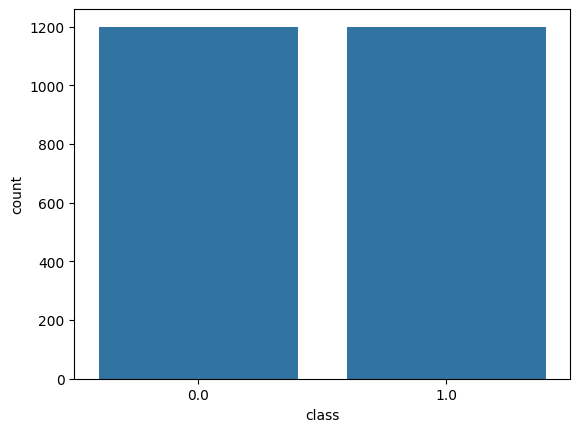

In [158]:
# grab our seaborn visualization toolbox!
import seaborn as sns

### YOUR CODE HERE
metadata.groupby(['class']).count()
sns.countplot(x='class', data = metadata)
### END CODE

Next, we will split our data into different 'sets' that each will work differently with our model. **Think of our AI as a machine learning 'student'.**

**Training Set:** Our training set is like a training manual. Our algorithm will read, or 'train', on this over and over again to try and learn its task.

**Test Set:** Our test set is like a test. It is testing our model on problems that it has not seen before.

**We usually have a much larger training set than test set. Let's see if this is the case with our data!**


Notice that our 'split' designation is found in the metadata. Plot the count of each 'set' in our data below:

<Axes: xlabel='split', ylabel='count'>

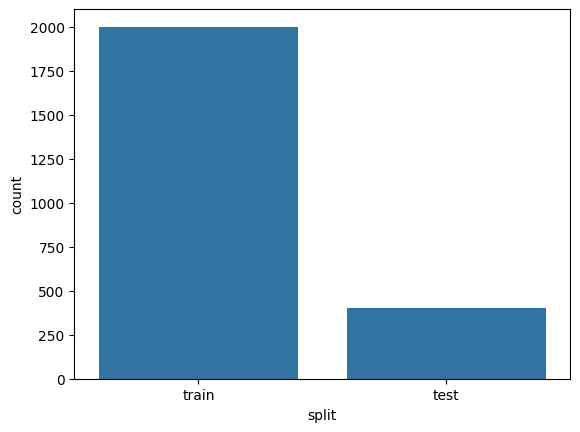

In [159]:
### YOUR CODE HERE
sns.countplot(x='split', data = metadata)

### END CODE

We are also interested in how many of each 'class' (**pneumonia** or **healthy**) we have in each 'split' (train or test)
group by set and count the classes: for example, how many of the Training Set images are pneumonia?

Try this out with your group! Some hints:
* If you use `.groupby()` along with `count()`, you can pass in a list of different variables.
* You can plot the count and add another variable called `hue` to be either `class` or `split` using the structure below:
```
sns.countplot(x = 'column_name', hue = 'column_name', data = data_table)
```


<Axes: xlabel='class', ylabel='count'>

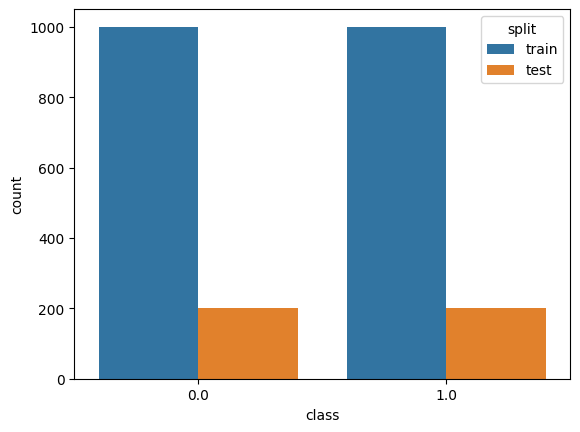

In [160]:
### YOUR CODE HERE
sns.countplot(x = 'class', hue = 'split', data = metadata)
### END CODE

We will check what we think the data is against what python tells us it is. Let's start by loading in the data and the labels:


In [161]:
X_train, y_train = get_train_data()

Try printing out `X_train.shape` and `y_train.shape`. Can you explain the results?

In [162]:
#YOUR CODE HERE
print(X_train.shape)
print(y_train.shape)

(2000, 64, 64, 3)
(2000,)


Now, let's look at a single image! Below, the outputs help us understand: **what kind of data is `single_image`? What are its dimensions? What is its label?**

In [163]:
image = X_train[0]
image_label = y_train[0]

print('Our image is stored as %s in Python'%type(image))
print('Our image has dimensions of (%d, %d, %d)'%image.shape)
print('Our image has label %d'%image_label)

Our image is stored as <class 'numpy.ndarray'> in Python
Our image has dimensions of (64, 64, 3)
Our image has label 0


In [164]:
#@title What does image shape represent? { display-mode: "form" }

#@markdown What does the bold number (**64**, 64, 3) represent?
Dimension_0  = "image height" #@param ["Your answer", "image width", "image height","number of colors"]

#@markdown What does the bold number (64, **64**, 3) represent?
Dimension_1  = "image width" #@param ["Your answer", "image width", "image height","number of colors"]

#@markdown What does the bold number (64, 64, **3**) represent?
Dimension_2  = "number of colors" #@param ["Your answer", "image width", "image height","number of colors"]

if Dimension_0 == 'image height':
  print("Yes! Dimension_0 is the height of the image.")
else:
  print("Try again for Dimension_0!")

if Dimension_1 == 'image width':
  print("Yes! Dimension_1 is the width of the image.")
else:
  print("Try again for Dimension_1!")

if Dimension_2 == 'number of colors':
  print("Yes! Dimension_2 stands for 3 colors - (r,g,b).")
else:
  print("Try again for Dimension_2!")


Yes! Dimension_0 is the height of the image.
Yes! Dimension_1 is the width of the image.
Yes! Dimension_2 stands for 3 colors - (r,g,b).


**Visualize single image with plot_images**

Remember our `plot_one_image` function from last week? We'll use that with our data to view our images! Let's see a single image.

`plot_images` can take in either one image or many images. To use it with one image that is 3D, call:

```
plot_images(image)
```

To use it with many images, call:


```
plot_images(data, labels, index)
```

where:
* `data`: all of our images in one array
* `labels`: the labels corresponding to the images
* `index`: which image we want to see


In [165]:
image

array([[[0.18431373, 0.18431373, 0.18431373],
        [0.27450982, 0.27450982, 0.27450982],
        [0.33333334, 0.33333334, 0.33333334],
        ...,
        [0.27450982, 0.27450982, 0.27450982],
        [0.20000002, 0.20000002, 0.20000002],
        [0.03529412, 0.03529412, 0.03529412]],

       [[0.1254902 , 0.1254902 , 0.1254902 ],
        [0.26666668, 0.26666668, 0.26666668],
        [0.34117648, 0.34117648, 0.34117648],
        ...,
        [0.27450982, 0.27450982, 0.27450982],
        [0.14901961, 0.14901961, 0.14901961],
        [0.01568628, 0.01568628, 0.01568628]],

       [[0.16862746, 0.16862746, 0.16862746],
        [0.28235295, 0.28235295, 0.28235295],
        [0.34901962, 0.34901962, 0.34901962],
        ...,
        [0.23529413, 0.23529413, 0.23529413],
        [0.14901961, 0.14901961, 0.14901961],
        [0.05490196, 0.05490196, 0.05490196]],

       ...,

       [[0.        , 0.        , 0.        ],
        [0.1137255 , 0.1137255 , 0.1137255 ],
        [0.3529412 , 0

Label: 


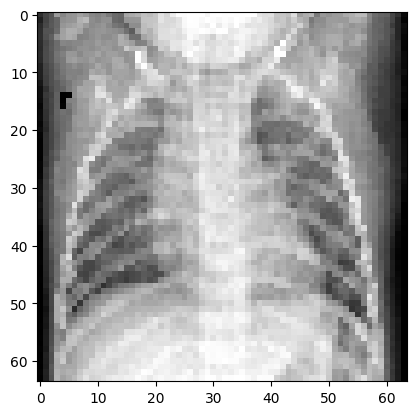

In [169]:
# plot a SINGLE image
### YOUR CODE HERE
plot_images(image)
### END CODE

Let's visualize a few more images from our data!

Label: 0.0


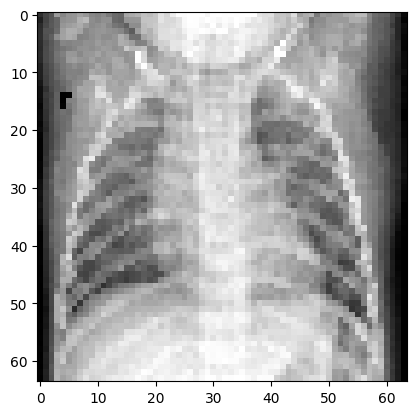

Label: 0.0


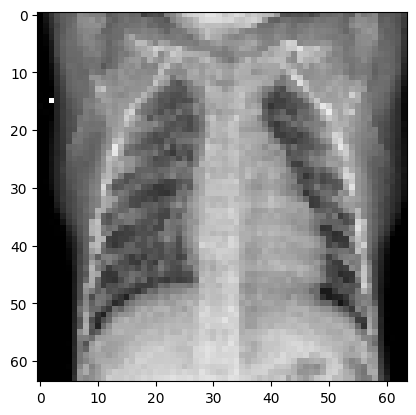

Label: 1.0


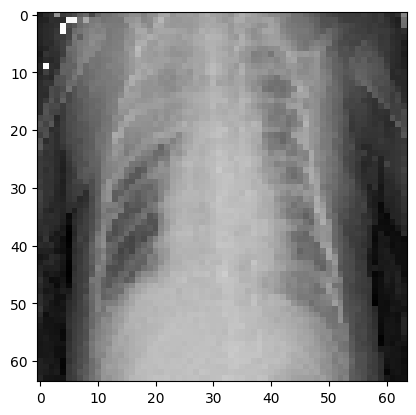

In [173]:
# use a for loop to visualize more images
for i in range(3):
  plot_images(X_train, y_train, i)
### YOUR CODE HERE
### END CODE

**Optional:** We might want to look at several **pneumonia** and **healthy** images **separately**. Modify your for loop to visualize **just pneumonia** and then **just healthy** images.

Label: 0.0


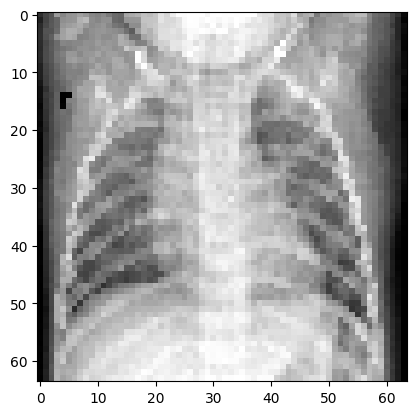

Label: 0.0


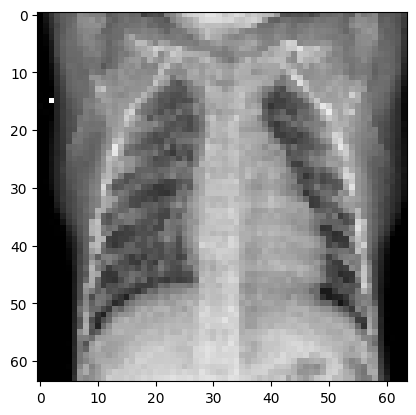

Label: 0.0


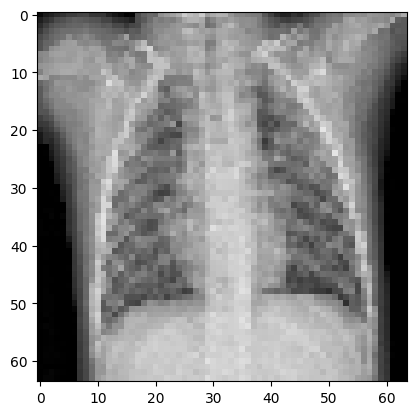

Label: 0.0


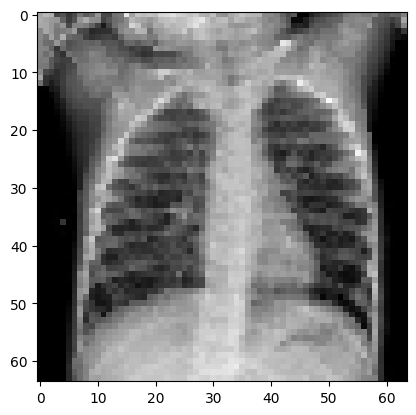

Label: 0.0


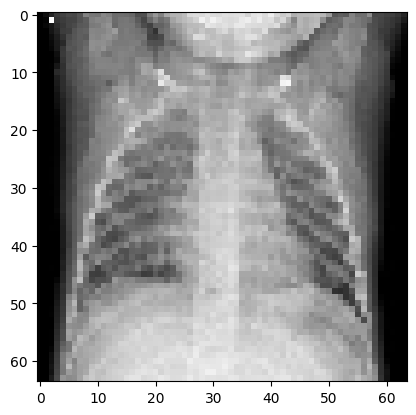

Label: 0.0


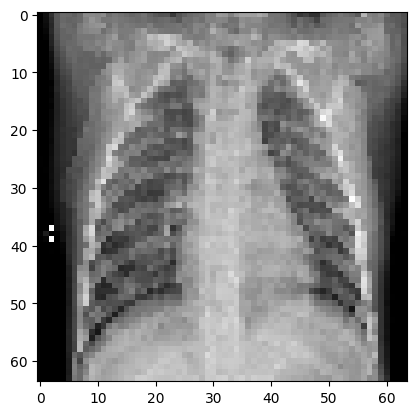

Label: 0.0


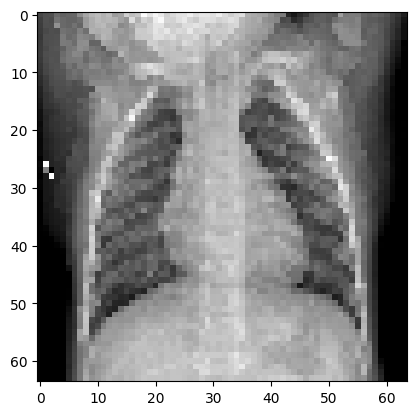

Label: 0.0


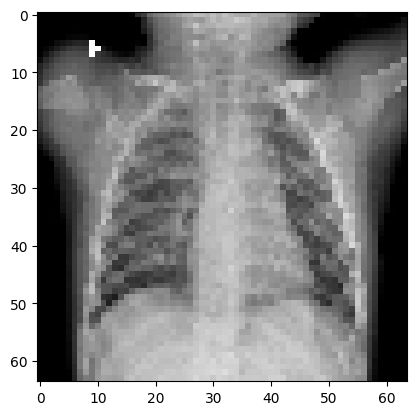

Label: 0.0


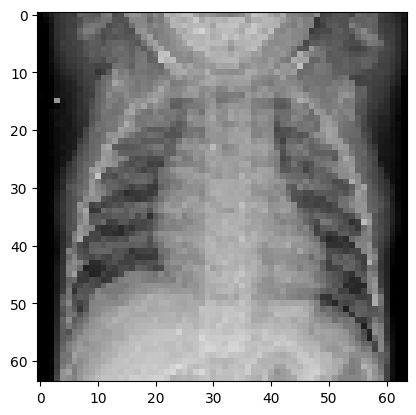

Label: 0.0


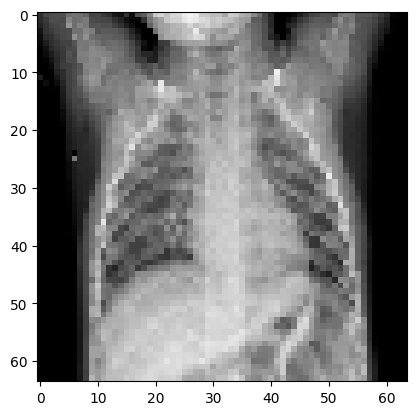

Label: 0.0


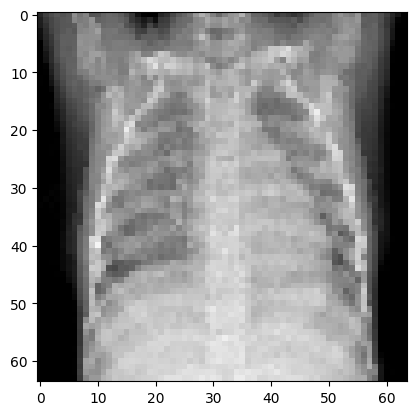

Label: 0.0


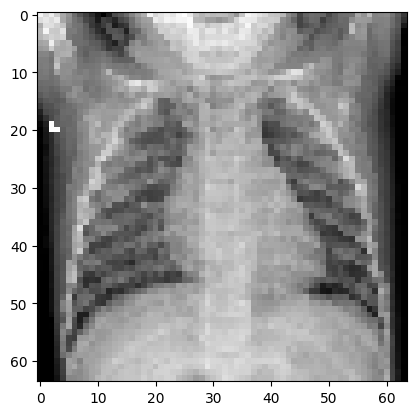

Label: 0.0


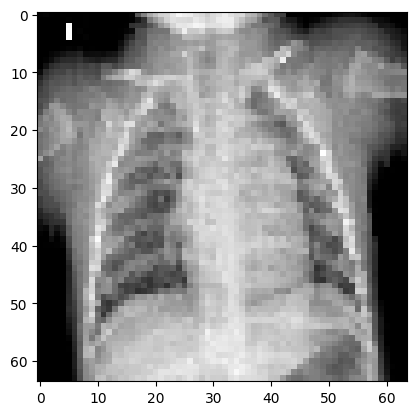

Label: 0.0


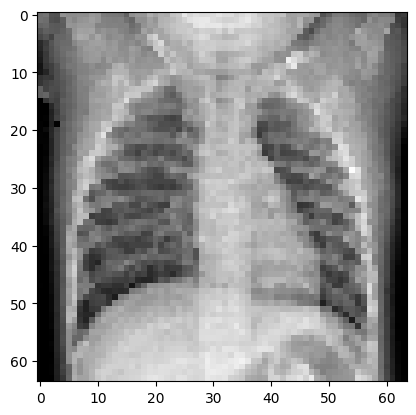

Label: 0.0


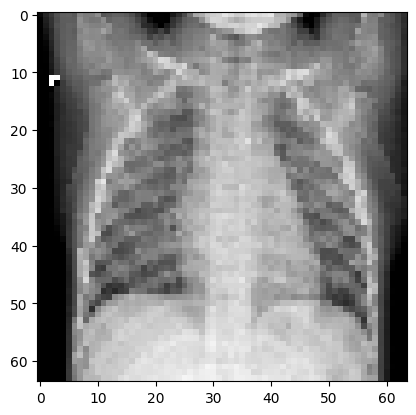

Label: 0.0


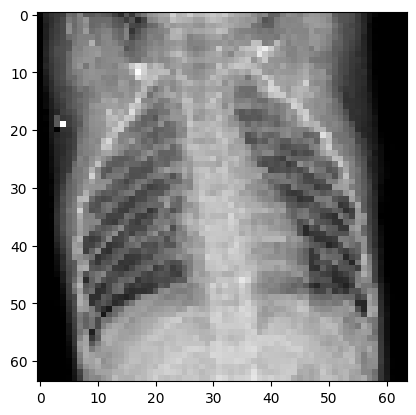

Label: 0.0


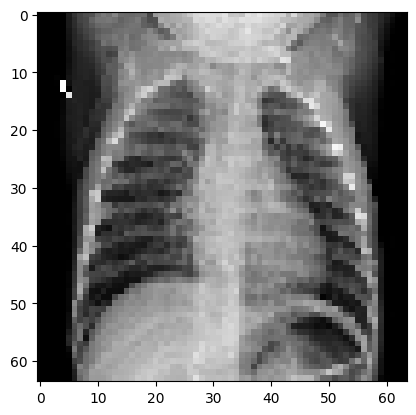

Label: 0.0


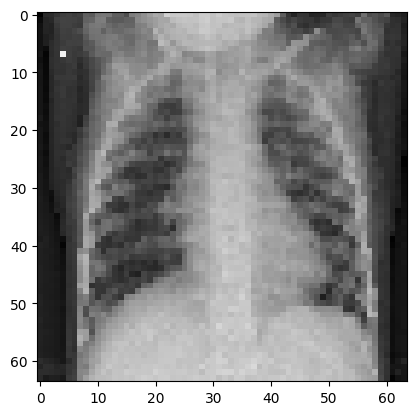

Label: 0.0


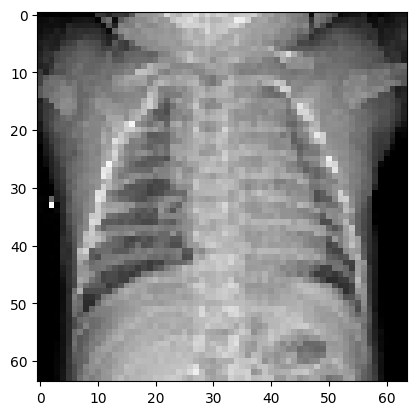

Label: 0.0


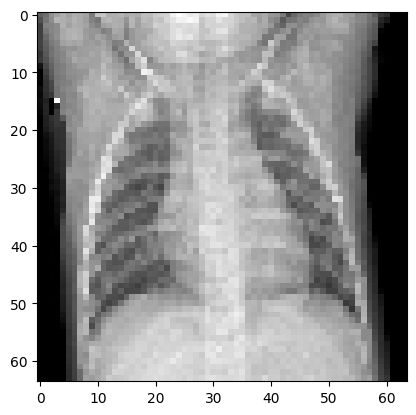

Label: 0.0


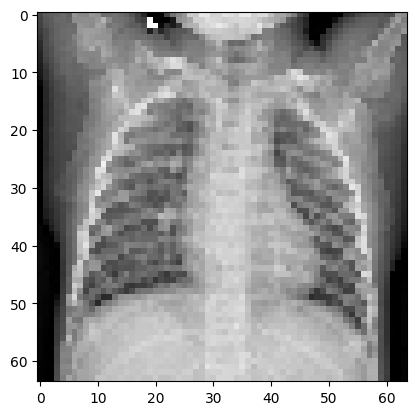

Label: 0.0


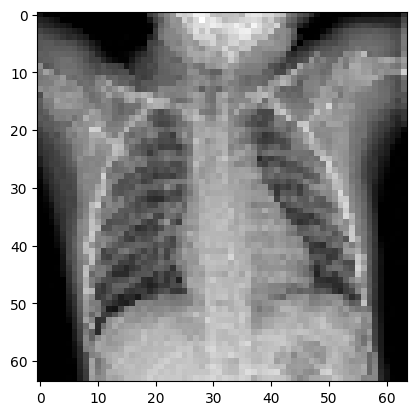

Label: 0.0


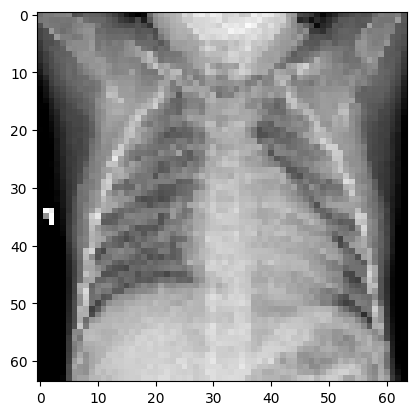

Label: 0.0


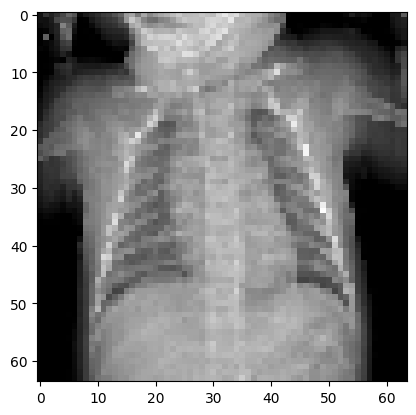

Label: 0.0


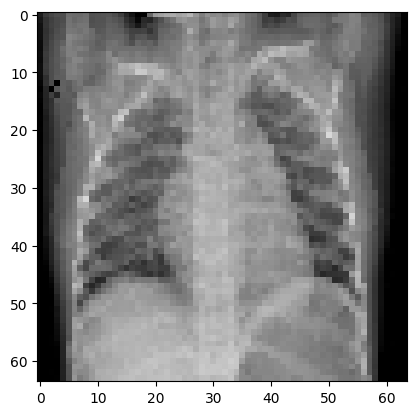

Label: 0.0


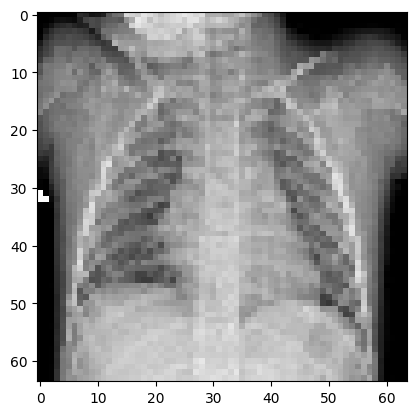

Label: 0.0


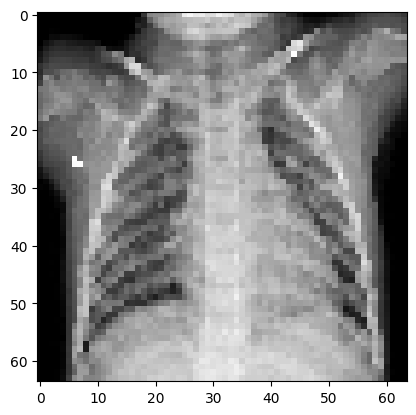

Label: 0.0


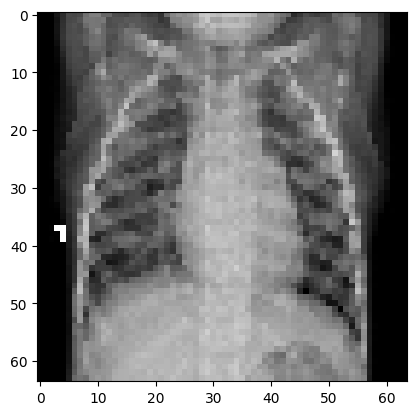

Label: 0.0


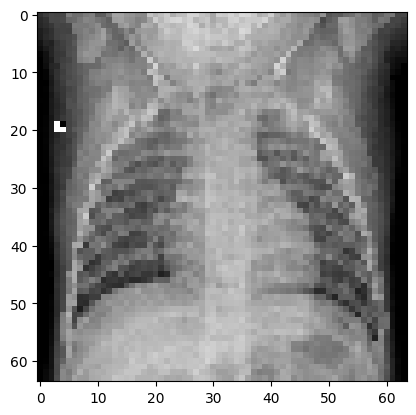

Label: 0.0


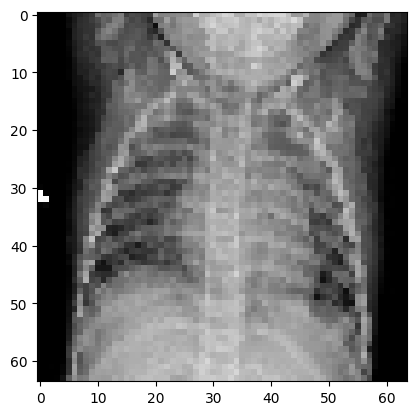

Label: 0.0


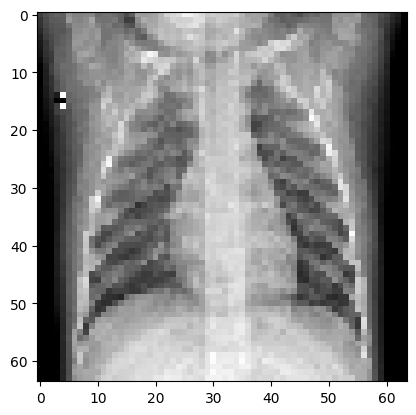

Label: 0.0


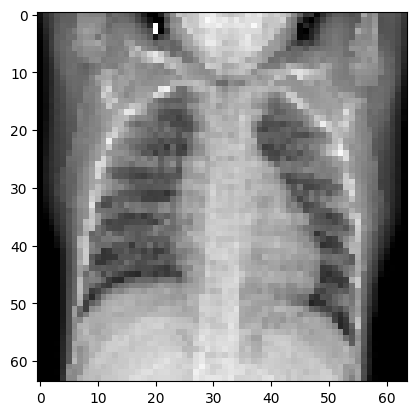

Label: 0.0


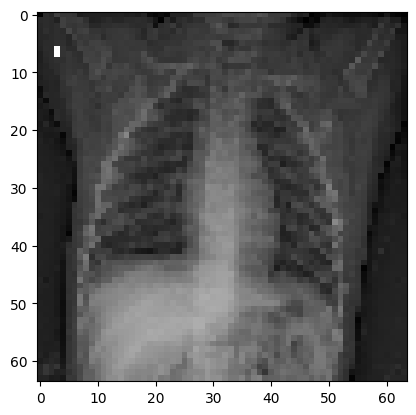

Label: 0.0


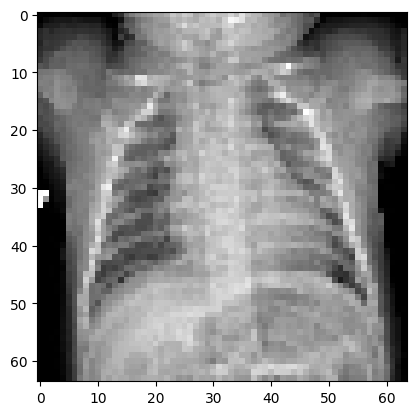

Label: 0.0


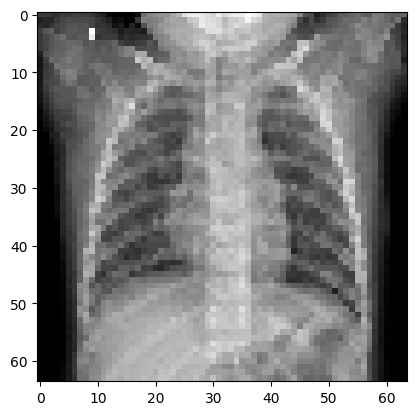

Label: 0.0


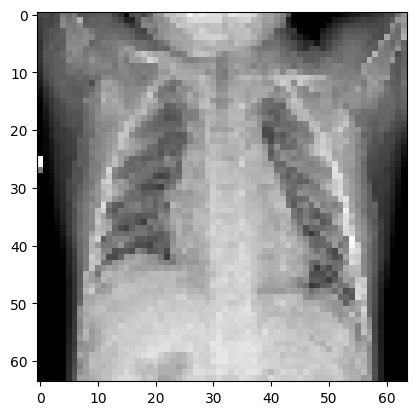

Label: 0.0


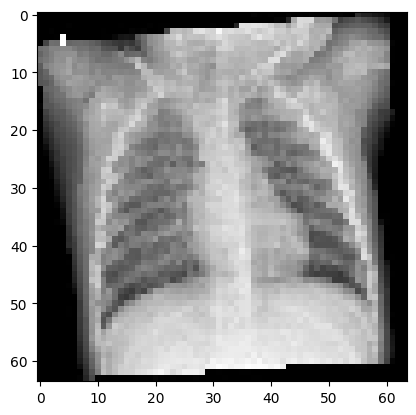

Label: 0.0


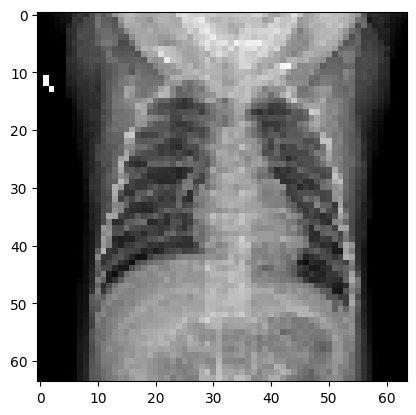

Label: 0.0


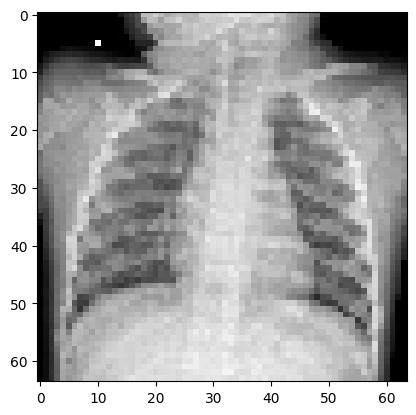

Label: 0.0


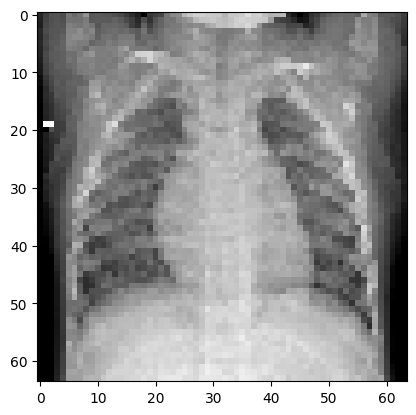

Label: 0.0


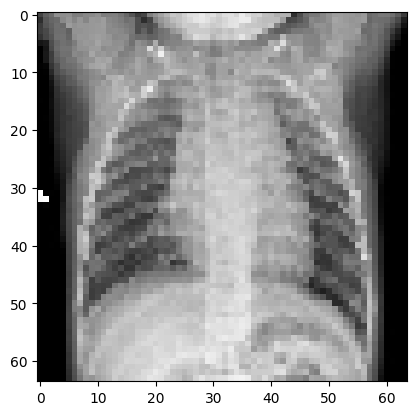

Label: 0.0


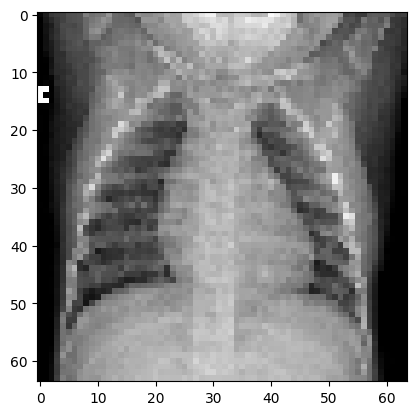

Label: 0.0


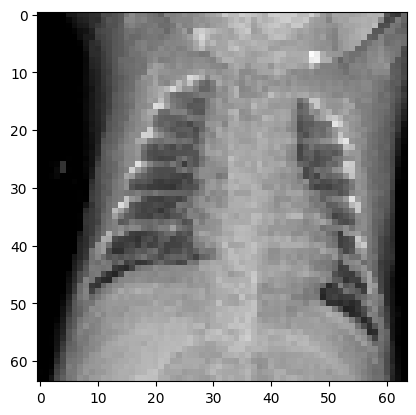

Label: 0.0


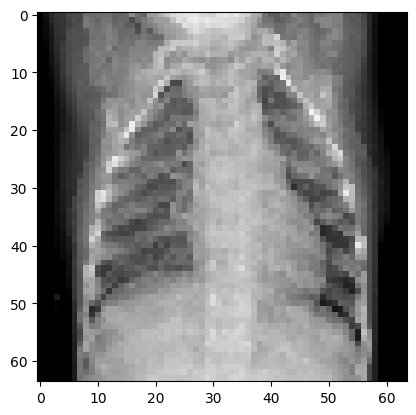

Label: 0.0


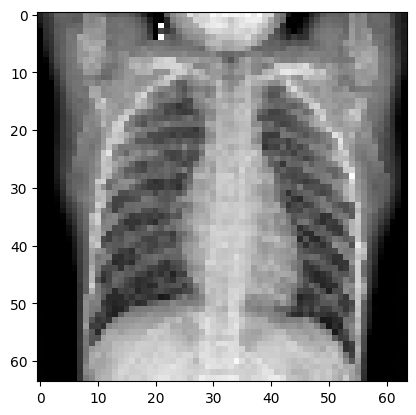

Label: 0.0


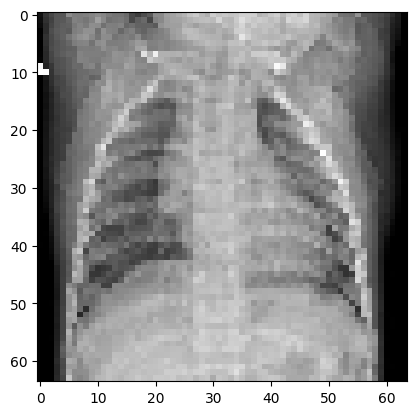

Label: 0.0


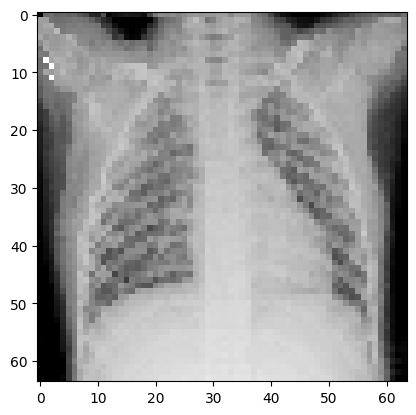

Label: 0.0


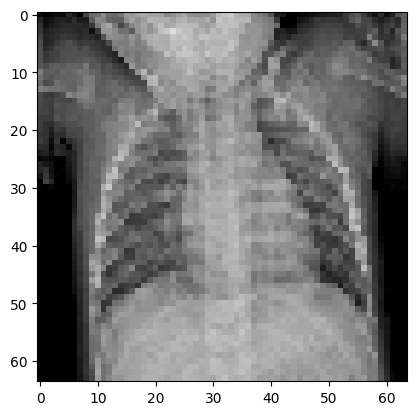

Label: 0.0


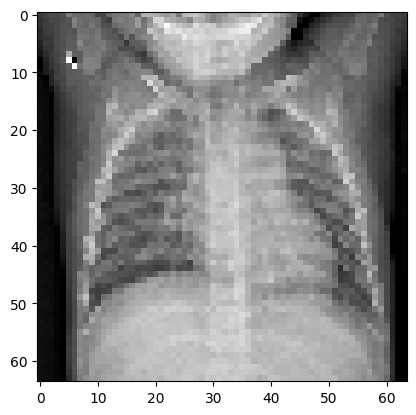

Label: 0.0


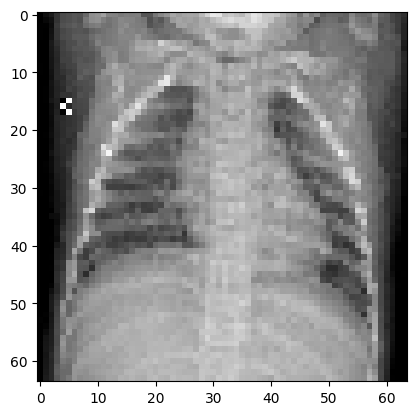

Label: 0.0


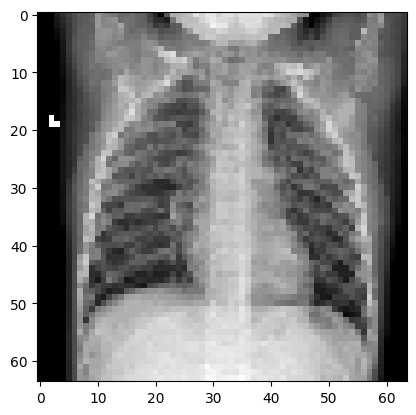

Label: 0.0


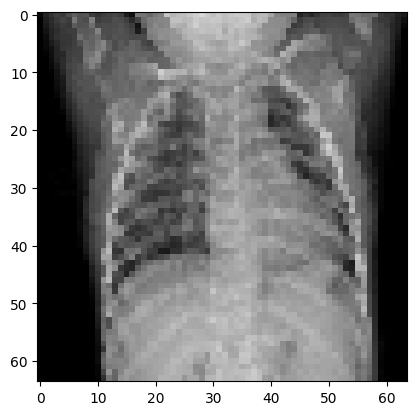

Label: 0.0


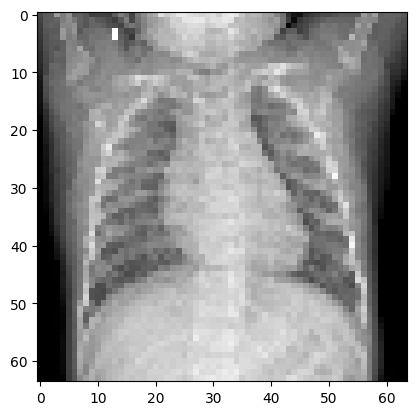

Label: 0.0


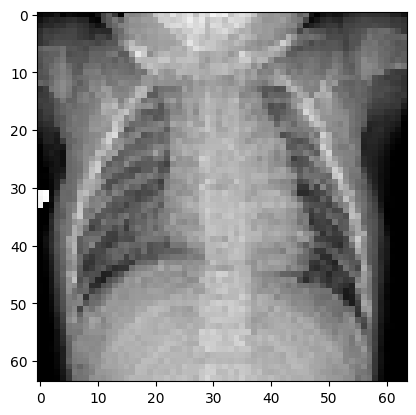

Label: 0.0


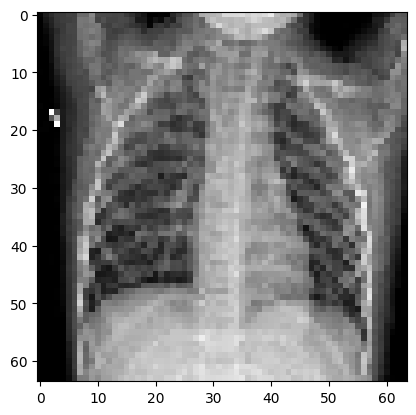

Label: 0.0


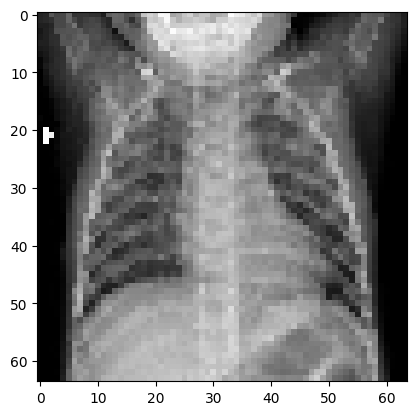

Label: 0.0


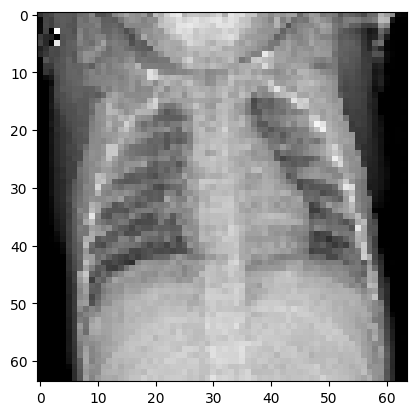

Label: 0.0


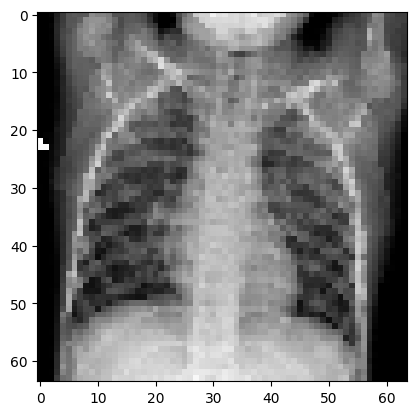

Label: 0.0


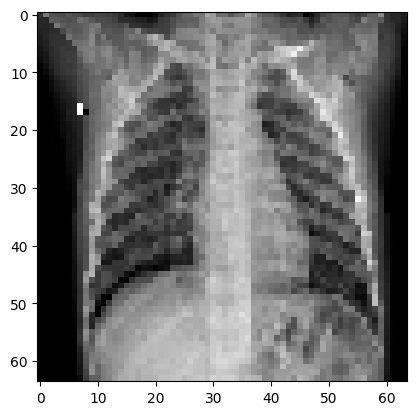

Label: 0.0


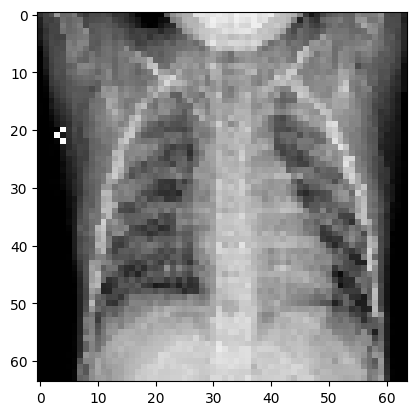

Label: 0.0


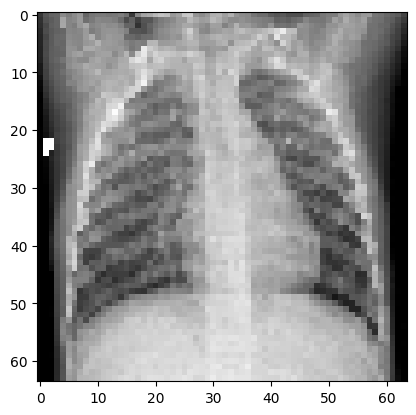

Label: 0.0


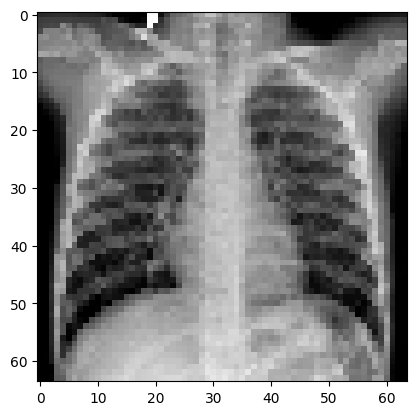

Label: 0.0


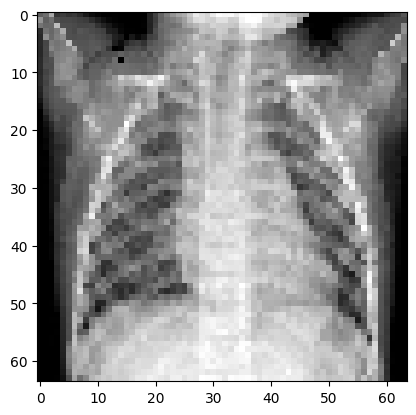

Label: 0.0


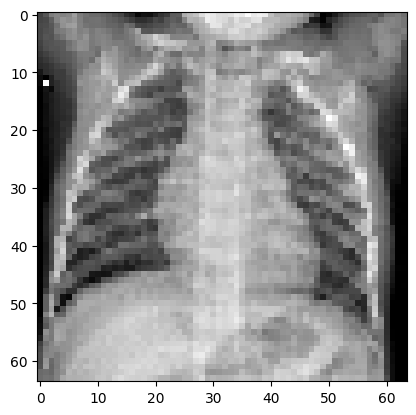

Label: 0.0


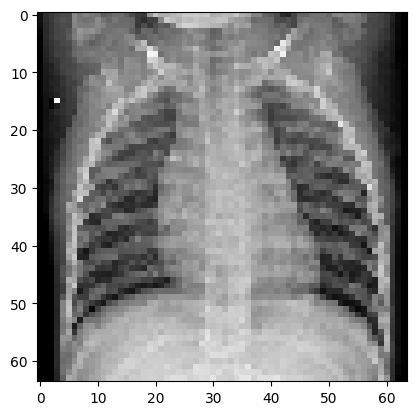

Label: 0.0


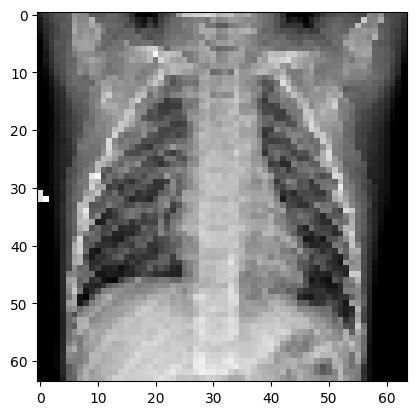

Label: 0.0


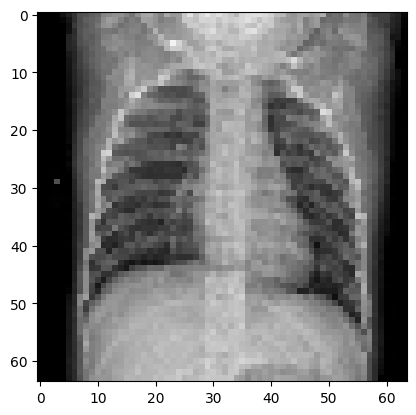

Label: 0.0


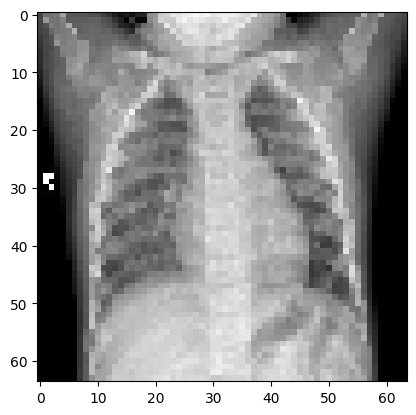

Label: 0.0


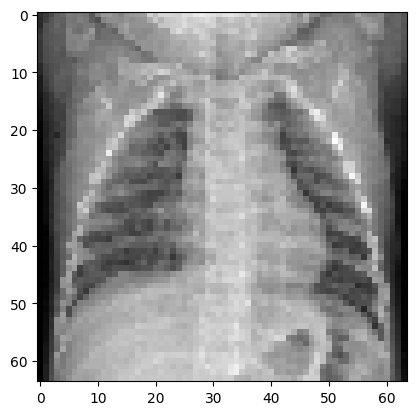

Label: 0.0


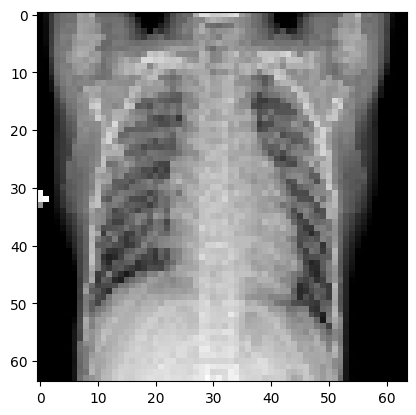

Label: 0.0


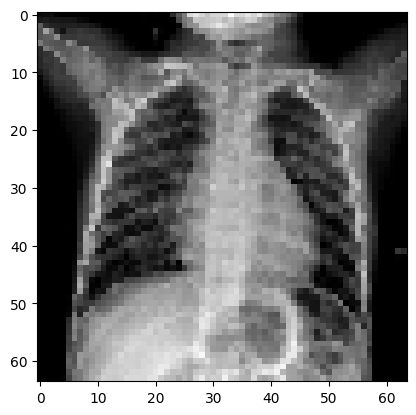

Label: 0.0


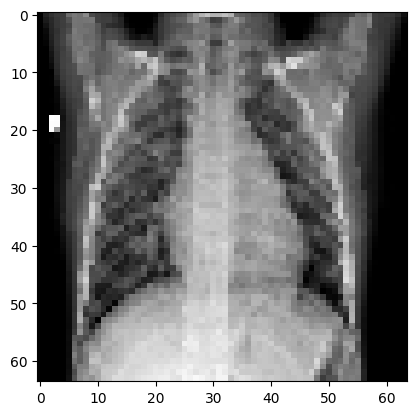

Label: 0.0


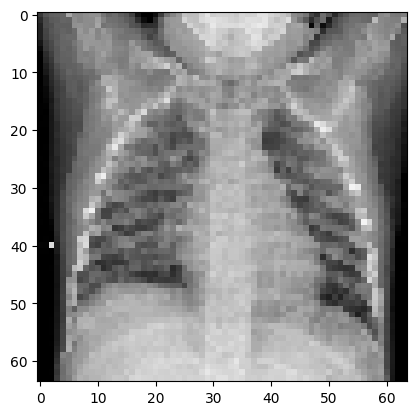

Label: 0.0


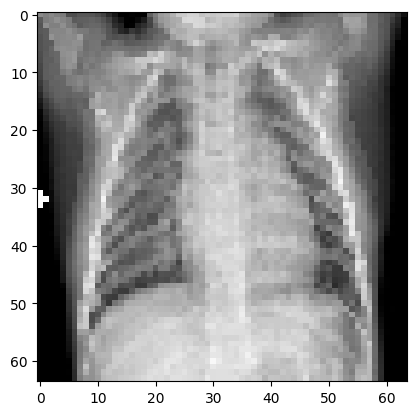

Label: 0.0


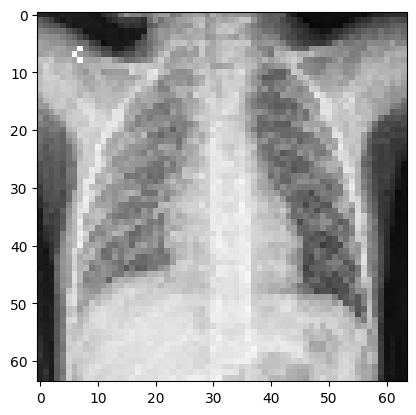

Label: 0.0


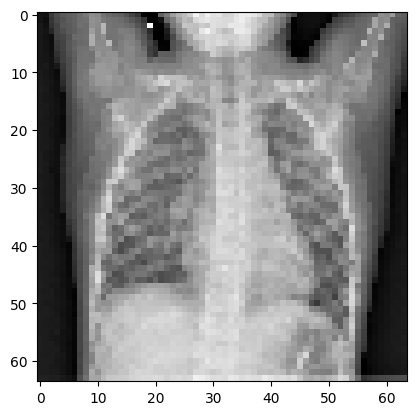

Label: 0.0


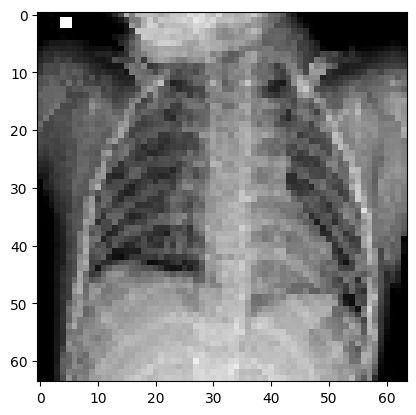

Label: 0.0


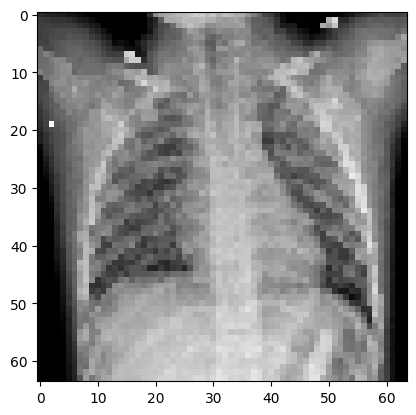

Label: 0.0


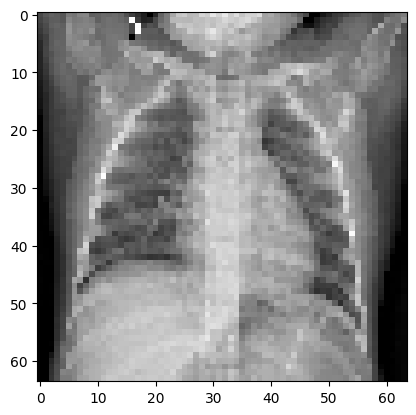

Label: 0.0


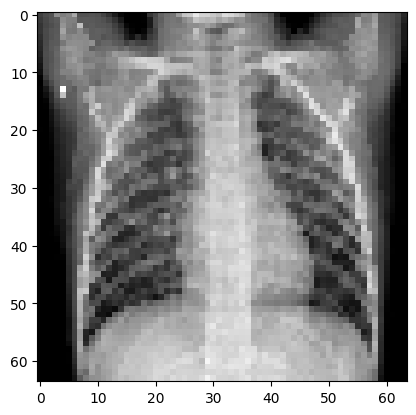

Label: 0.0


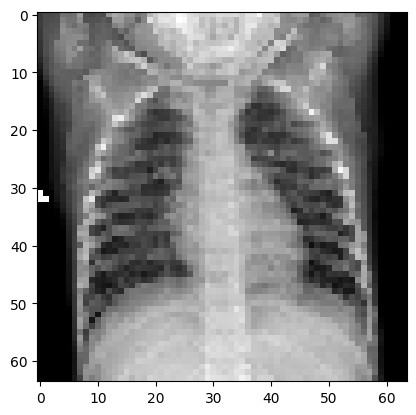

Label: 0.0


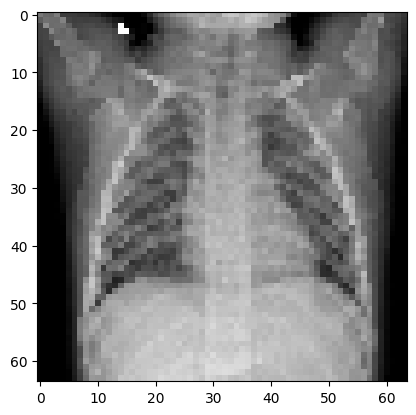

Label: 0.0


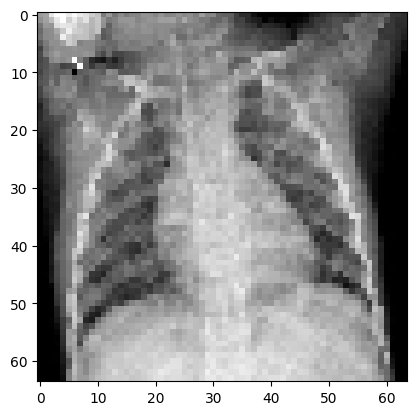

Label: 0.0


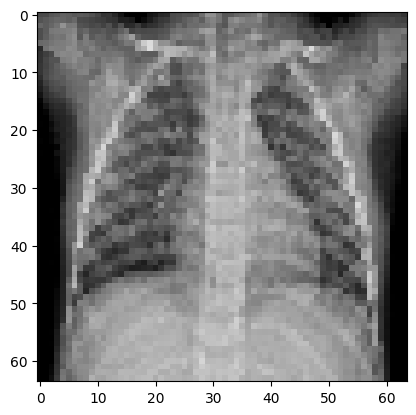

Label: 0.0


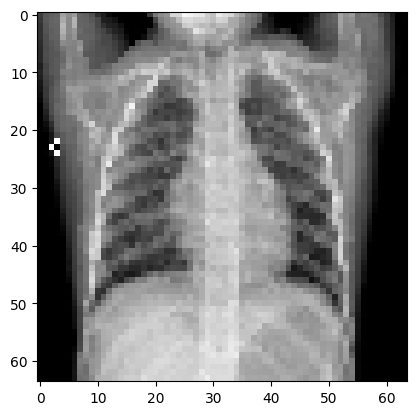

Label: 0.0


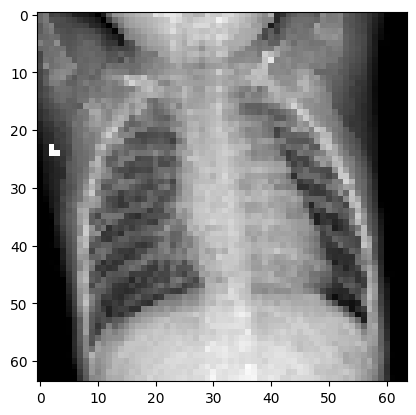

Label: 0.0


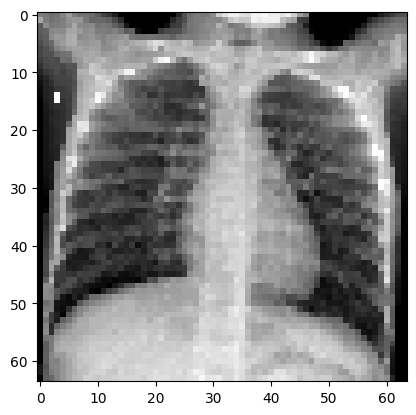

Label: 0.0


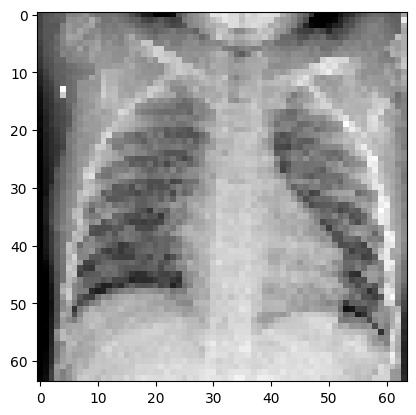

Label: 0.0


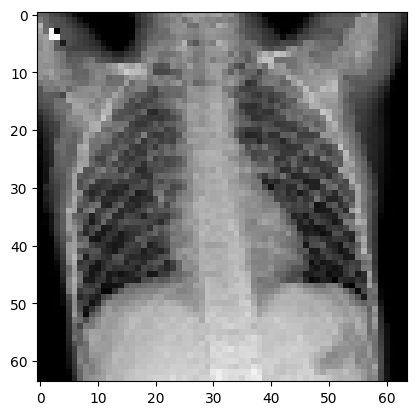

Label: 0.0


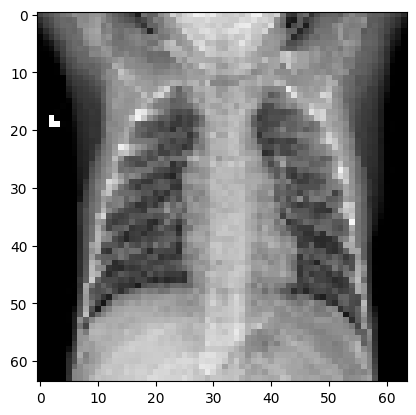

Label: 0.0


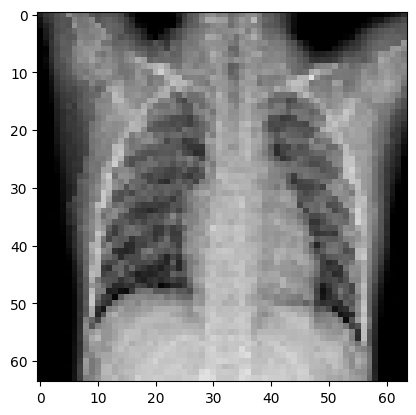

Label: 0.0


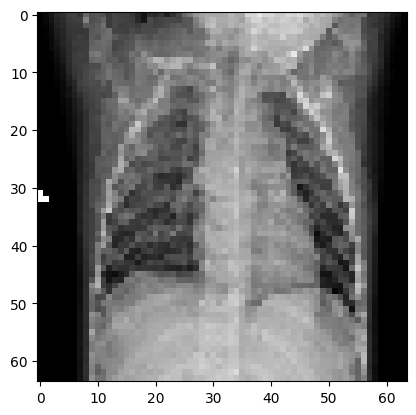

Label: 0.0


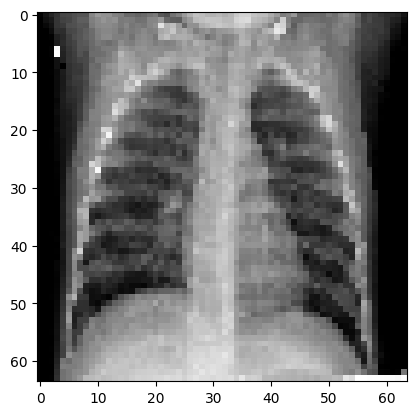

Label: 0.0


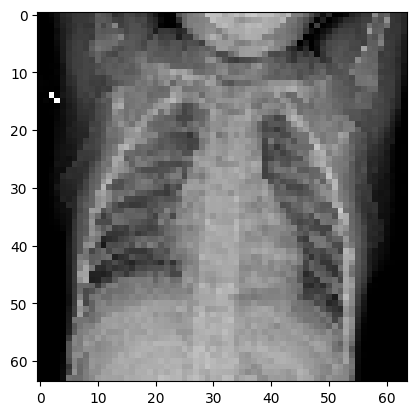

Label: 0.0


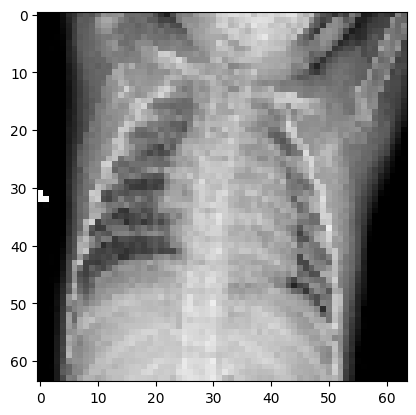

Label: 0.0


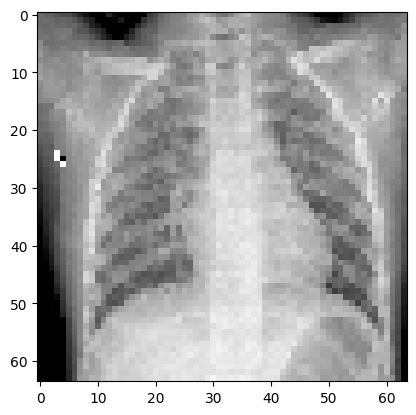

Label: 0.0


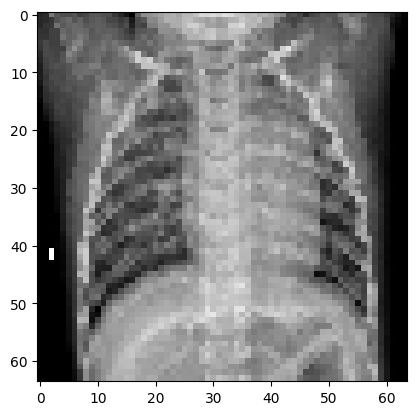

Label: 0.0


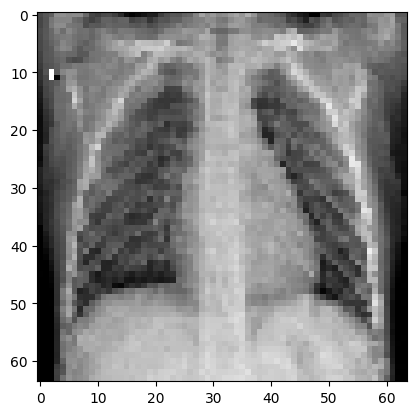

Label: 0.0


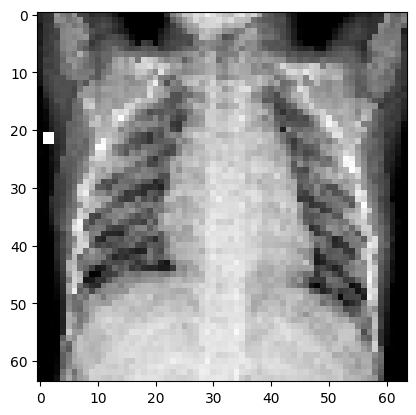

Label: 0.0


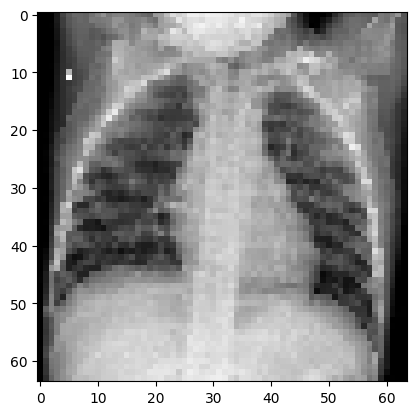

Label: 0.0


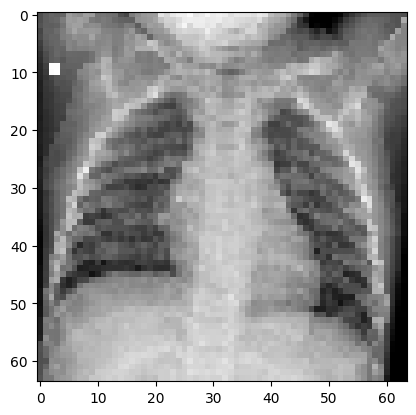

Label: 0.0


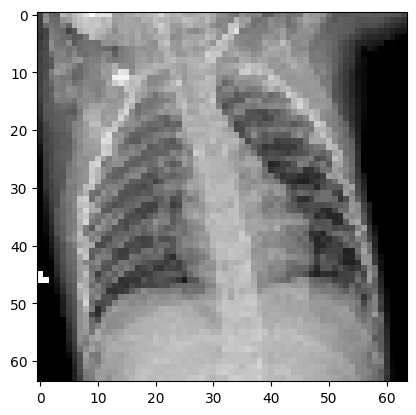

Label: 0.0


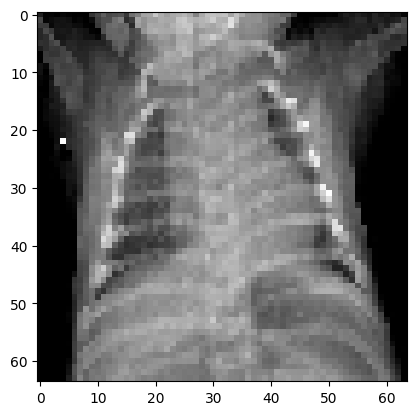

Label: 0.0


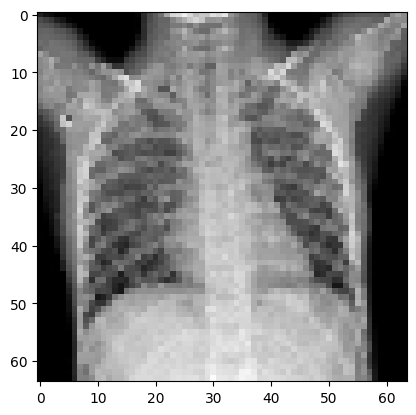

Label: 0.0


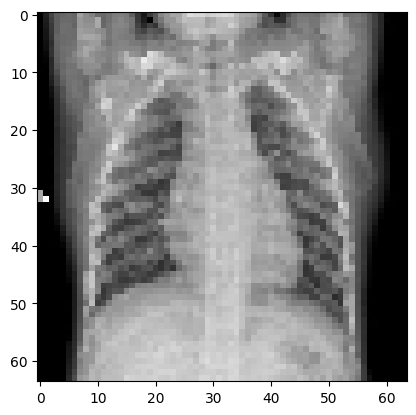

Label: 0.0


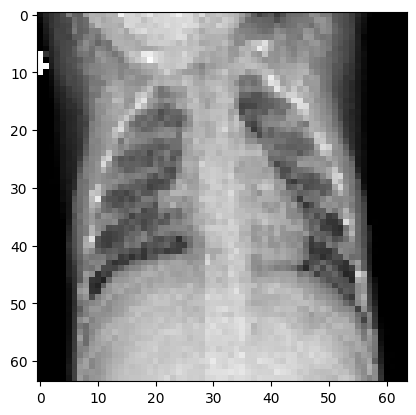

Label: 0.0


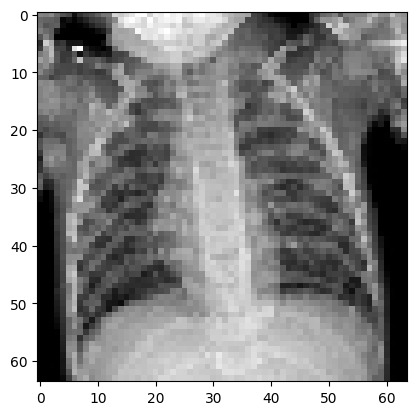

Label: 0.0


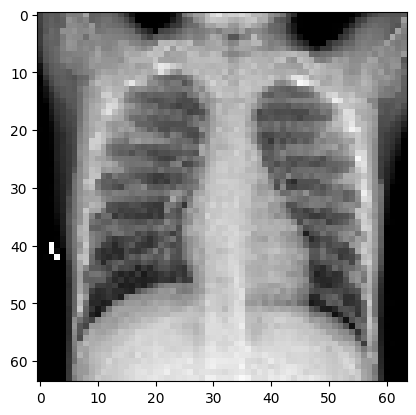

Label: 0.0


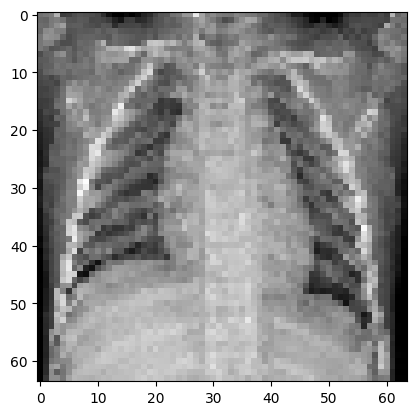

Label: 0.0


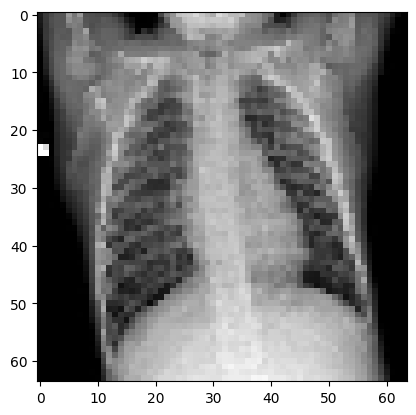

Label: 0.0


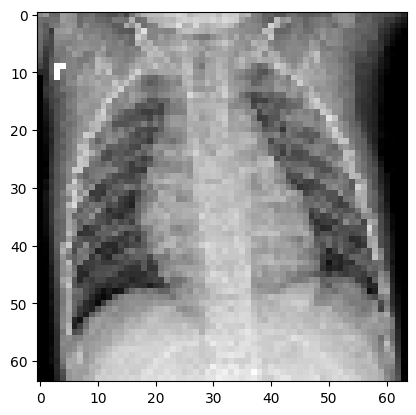

Label: 0.0


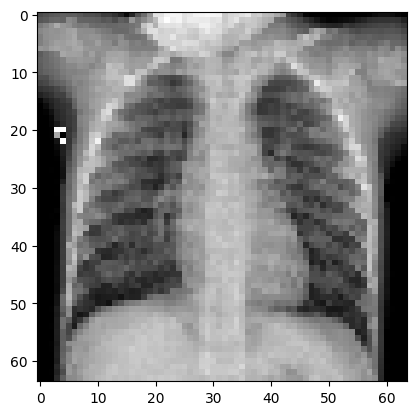

Label: 0.0


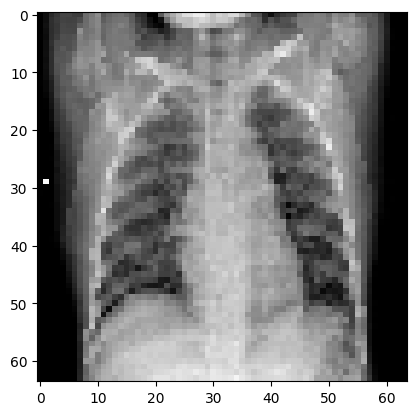

Label: 0.0


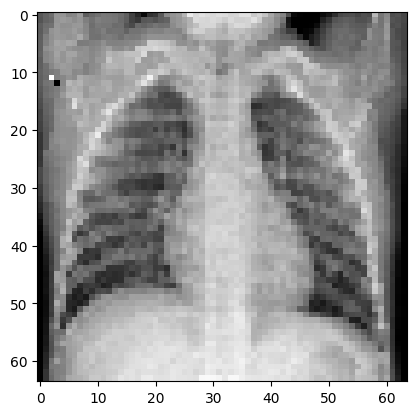

Label: 0.0


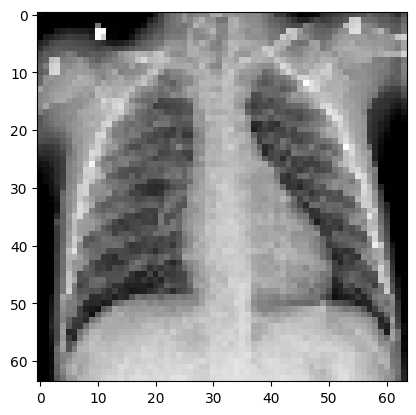

Label: 0.0


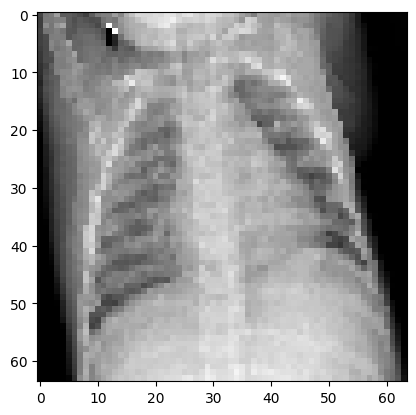

Label: 0.0


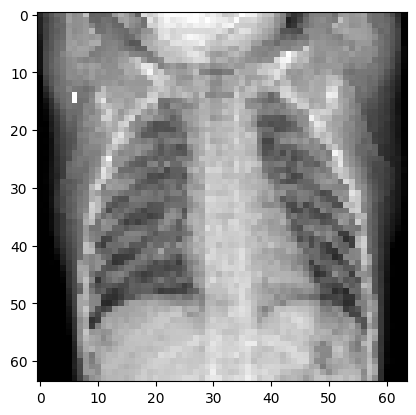

Label: 0.0


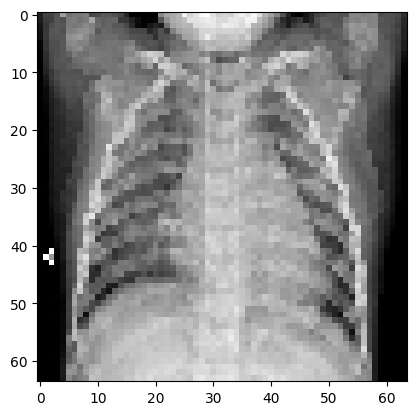

Label: 0.0


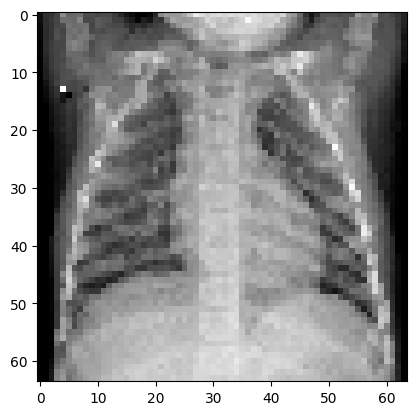

Label: 0.0


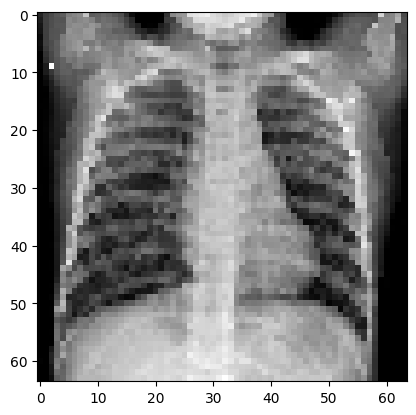

Label: 0.0


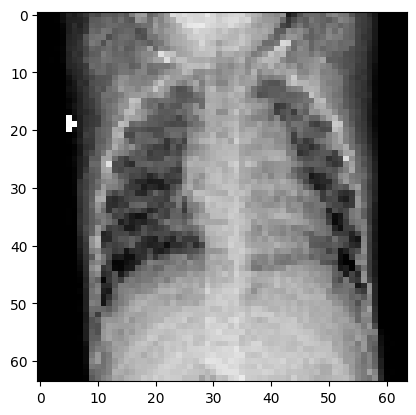

Label: 0.0


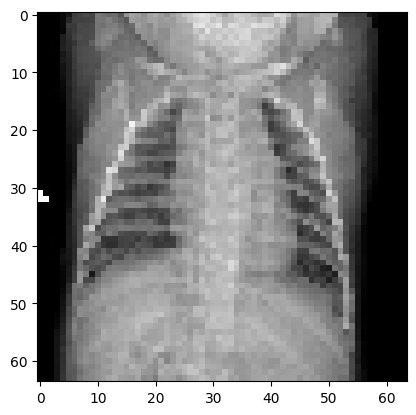

Label: 0.0


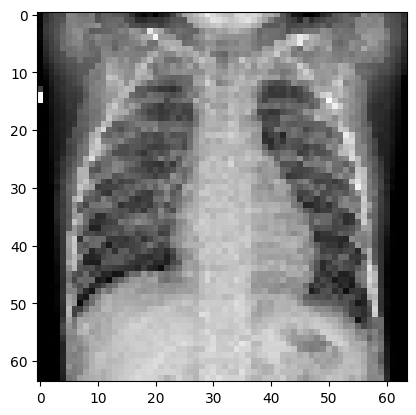

Label: 0.0


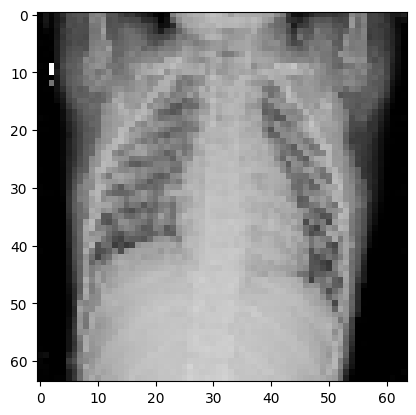

Label: 0.0


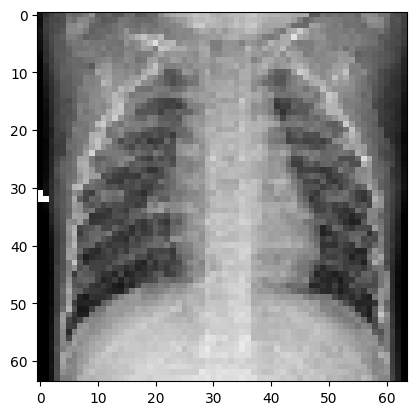

Label: 0.0


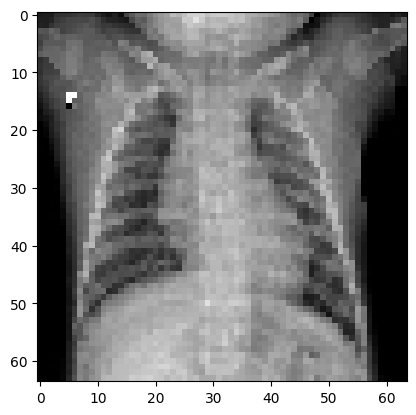

Label: 0.0


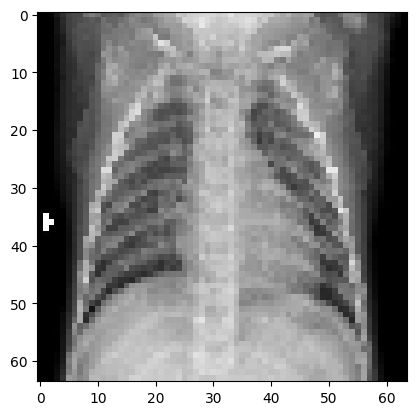

Label: 0.0


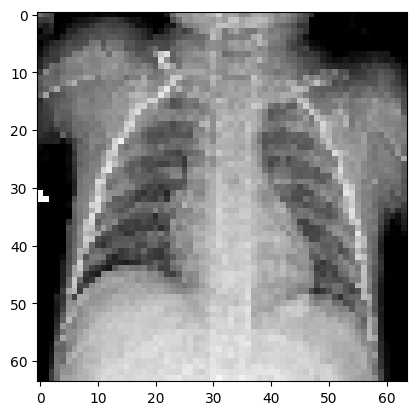

Label: 0.0


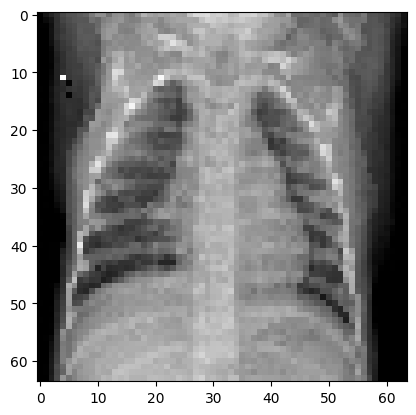

Label: 0.0


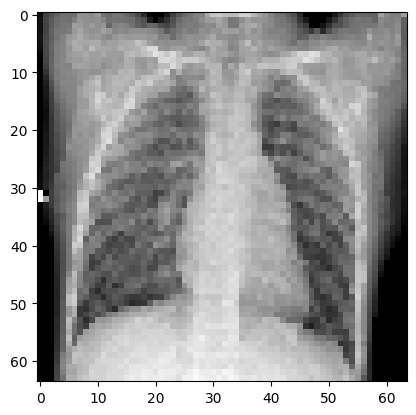

Label: 0.0


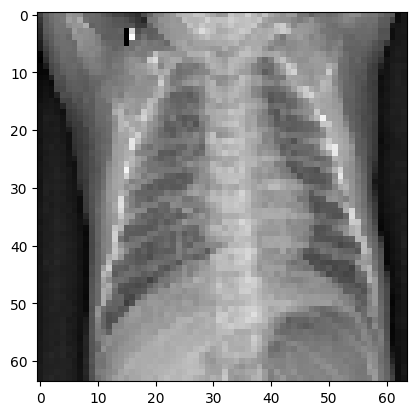

Label: 0.0


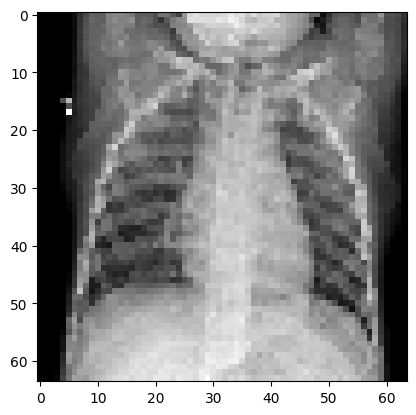

Label: 0.0


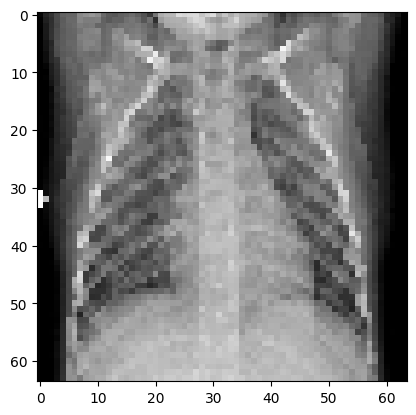

Label: 0.0


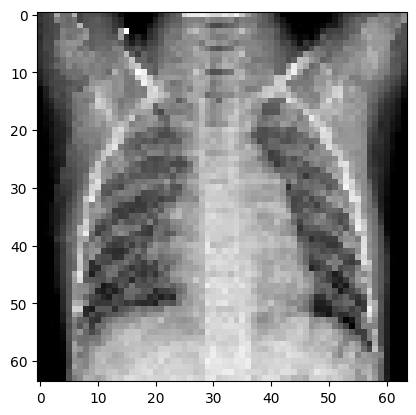

Label: 0.0


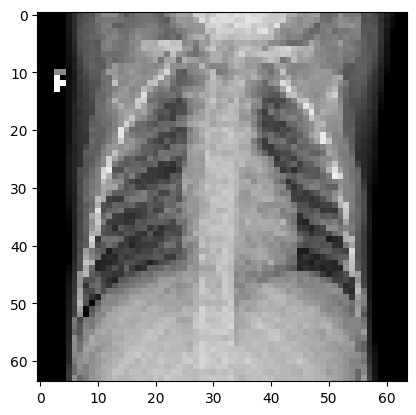

Label: 0.0


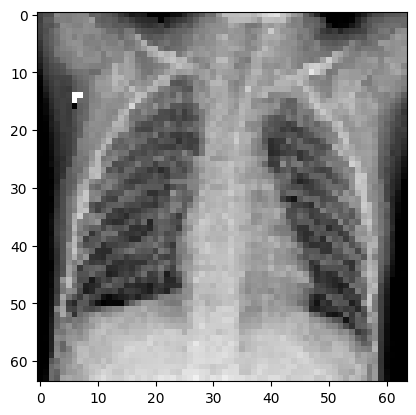

Label: 0.0


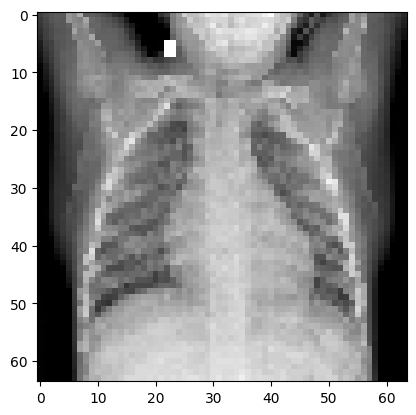

Label: 0.0


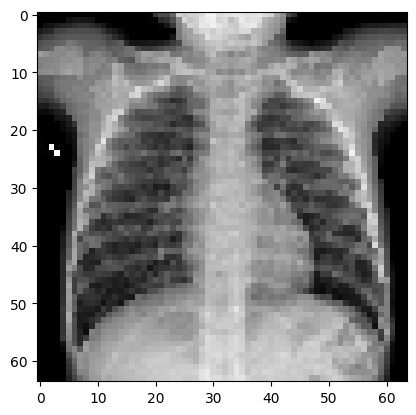

Label: 0.0


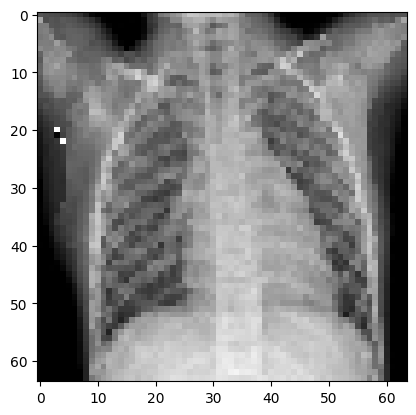

Label: 0.0


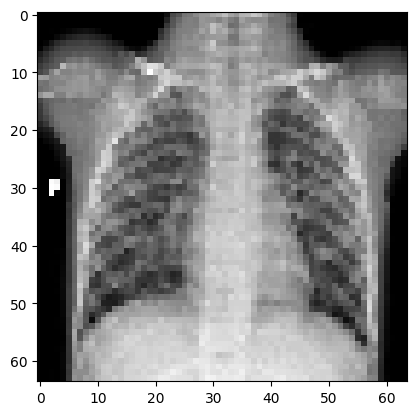

Label: 0.0


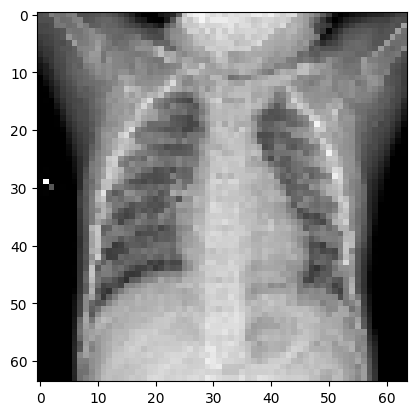

Label: 0.0


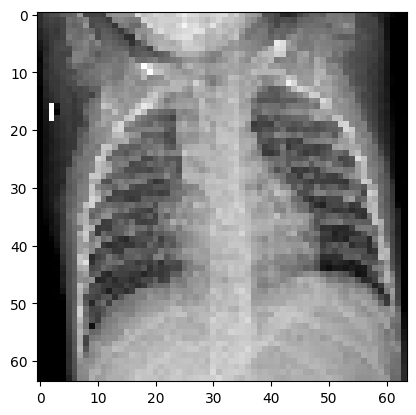

Label: 0.0


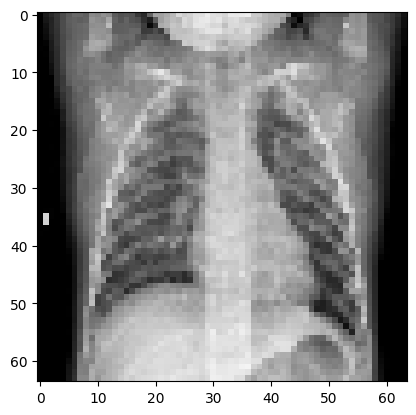

Label: 0.0


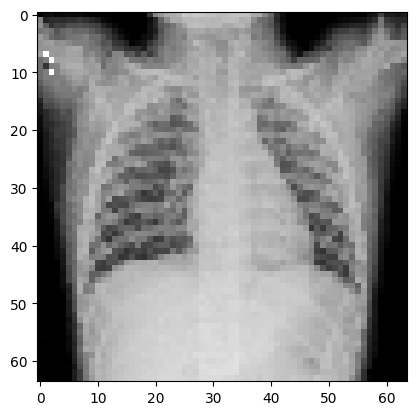

Label: 0.0


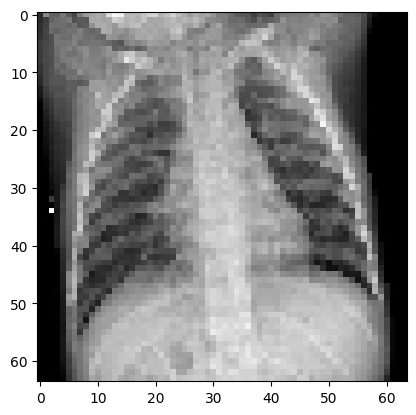

Label: 0.0


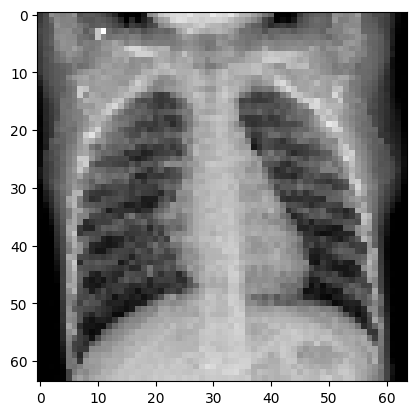

Label: 0.0


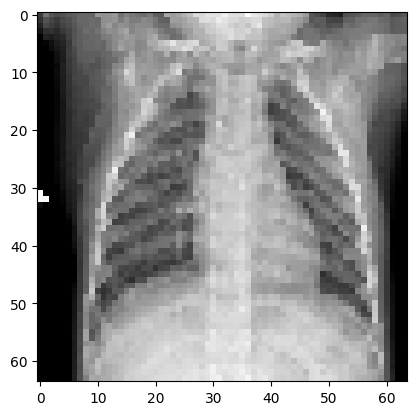

Label: 0.0


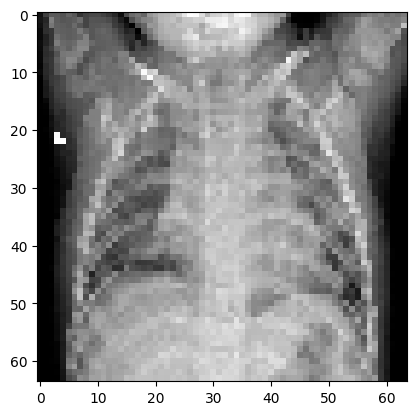

Label: 0.0


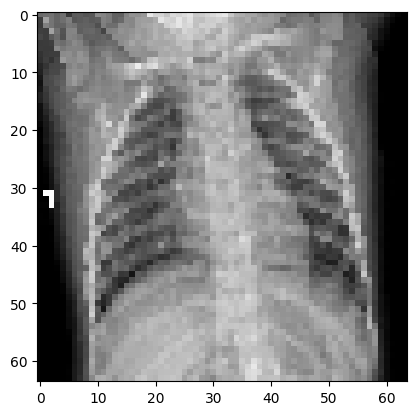

Label: 0.0


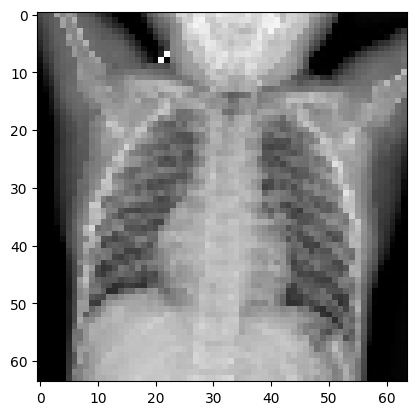

Label: 0.0


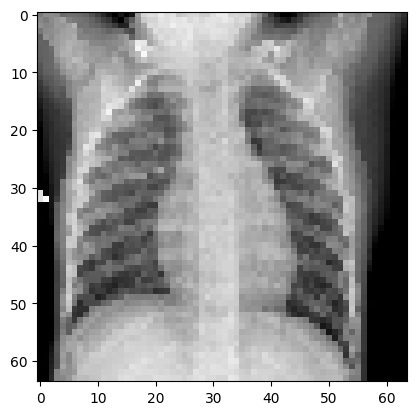

Label: 0.0


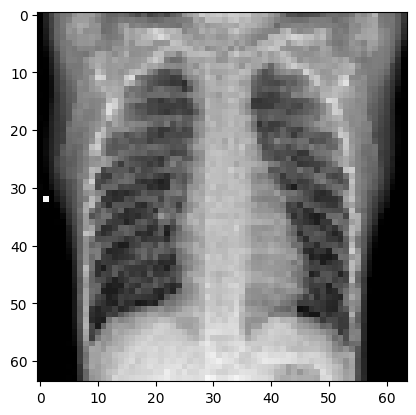

Label: 0.0


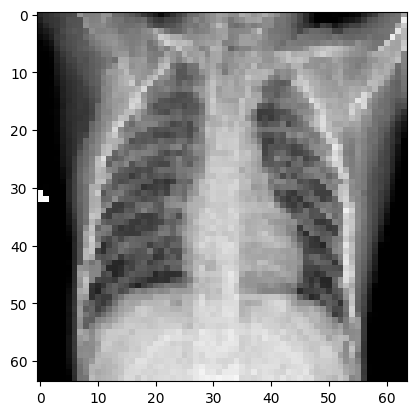

Label: 0.0


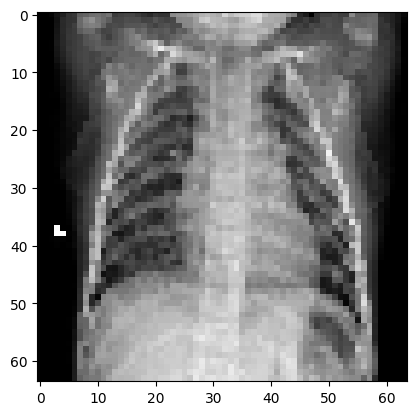

Label: 0.0


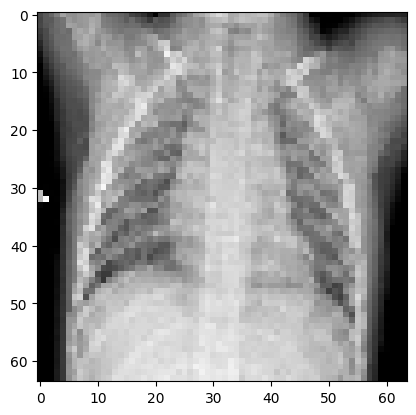

Label: 0.0


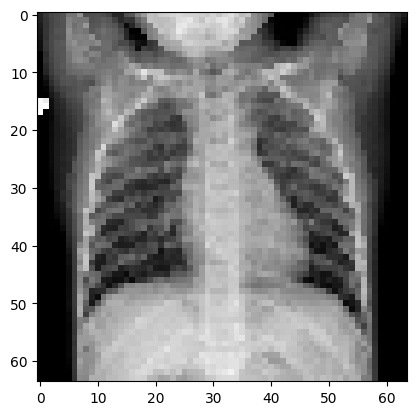

Label: 0.0


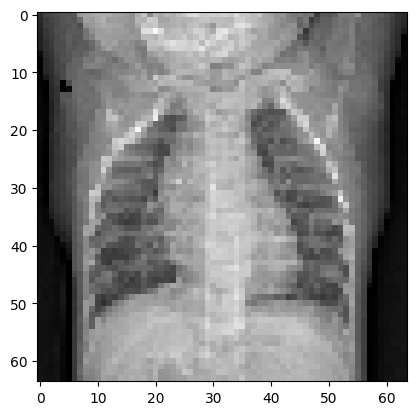

Label: 0.0


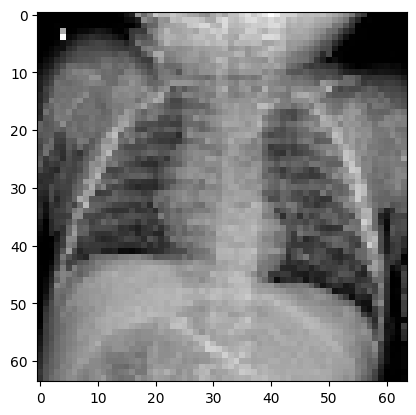

Label: 0.0


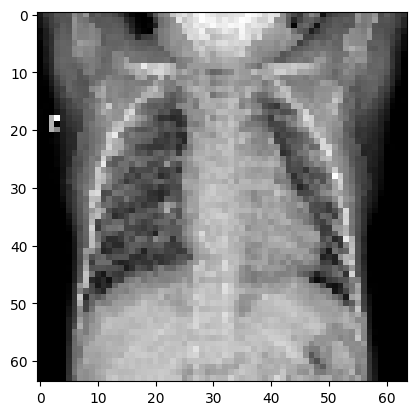

Label: 0.0


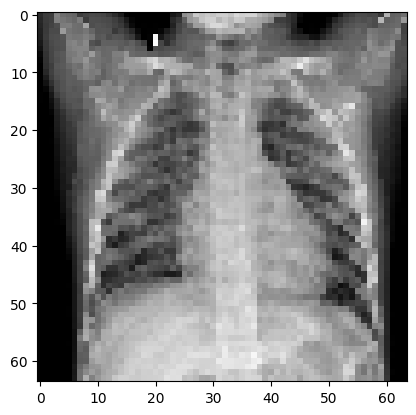

Label: 0.0


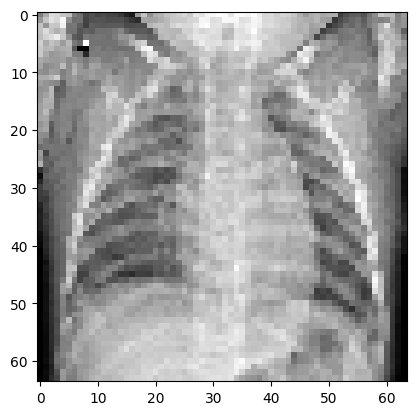

Label: 0.0


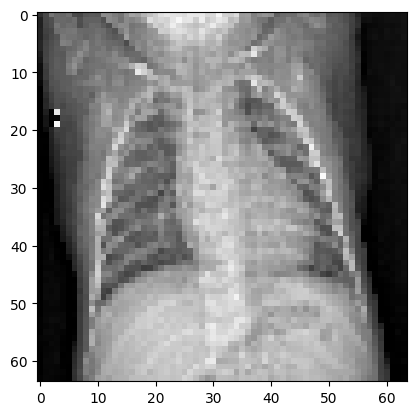

Label: 0.0


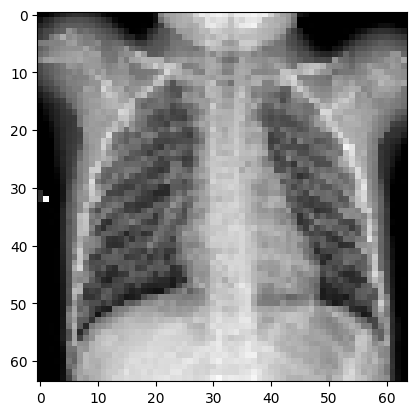

Label: 0.0


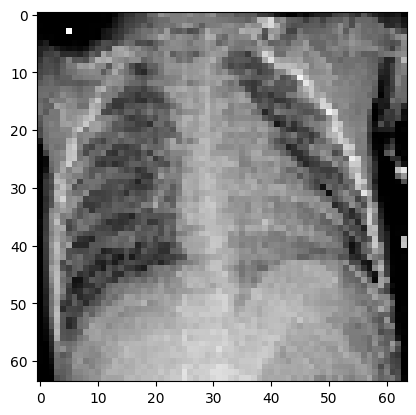

Label: 0.0


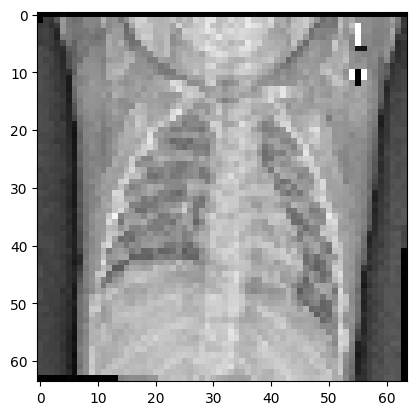

Label: 0.0


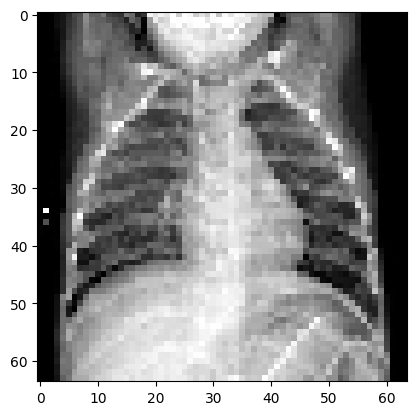

Label: 0.0


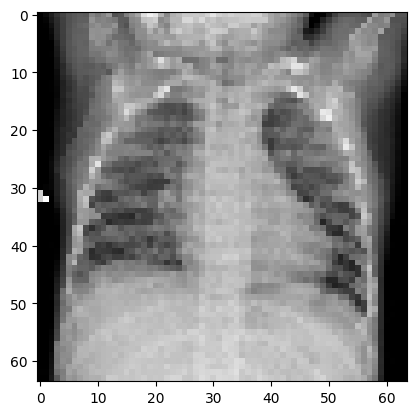

Label: 0.0


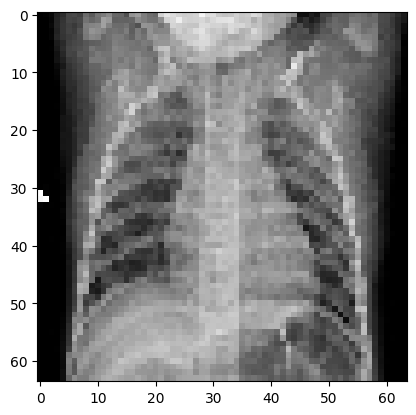

Label: 0.0


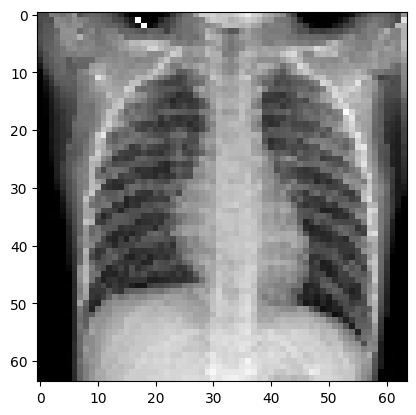

Label: 0.0


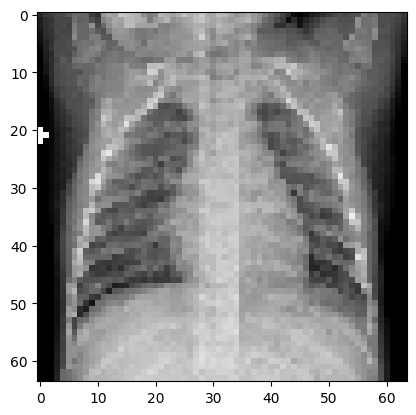

Label: 0.0


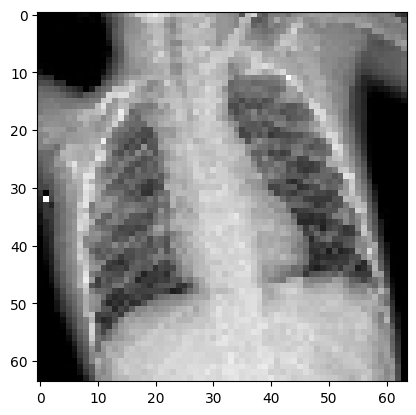

Label: 0.0


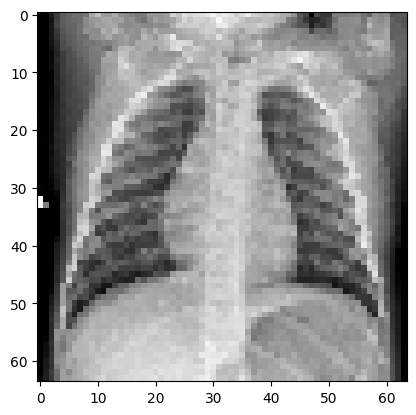

Label: 0.0


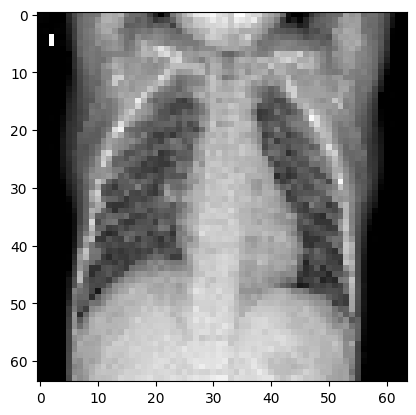

Label: 0.0


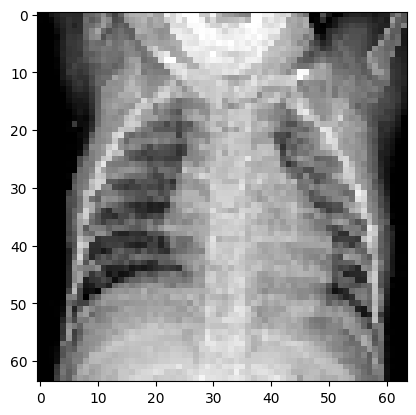

Label: 0.0


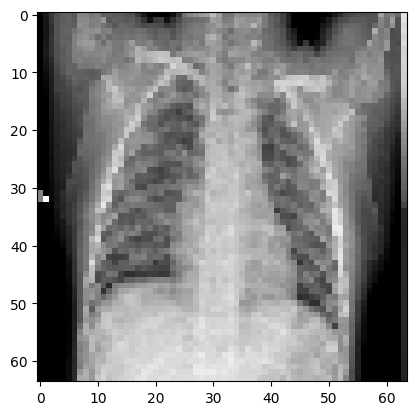

Label: 0.0


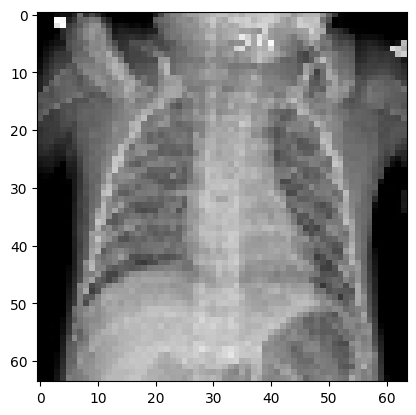

Label: 0.0


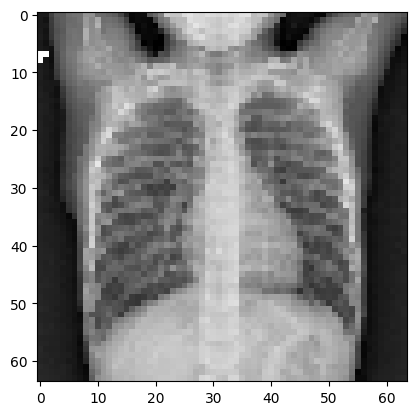

Label: 0.0


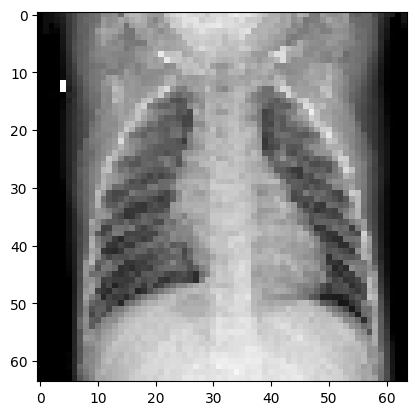

Label: 0.0


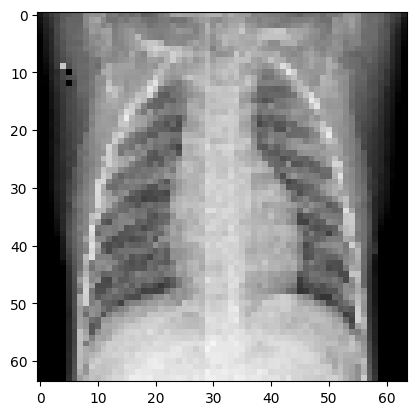

Label: 0.0


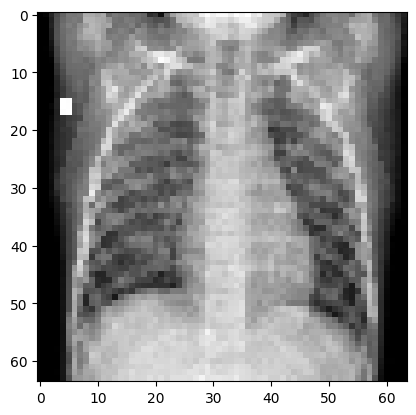

Label: 0.0


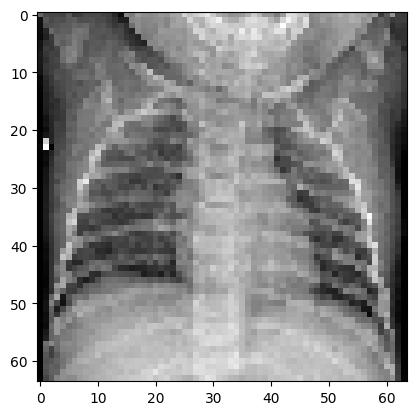

Label: 0.0


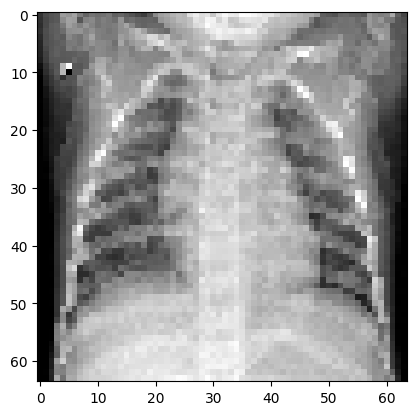

Label: 0.0


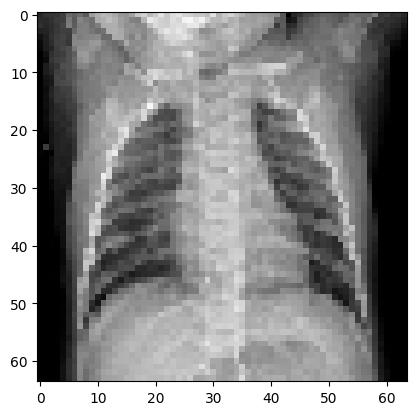

Label: 0.0


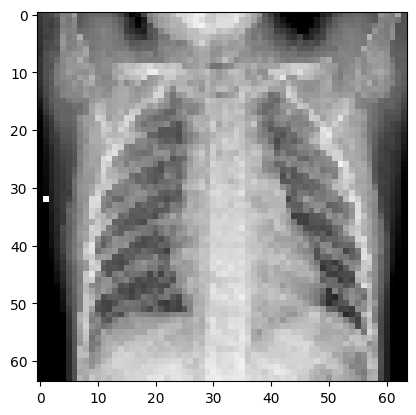

Label: 0.0


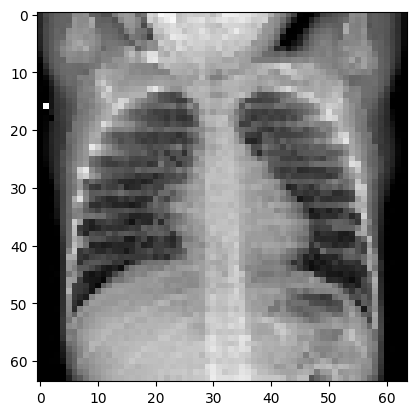

Label: 0.0


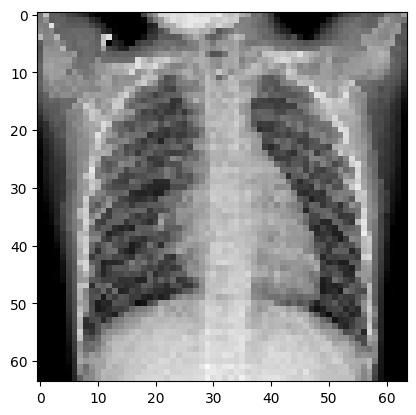

Label: 0.0


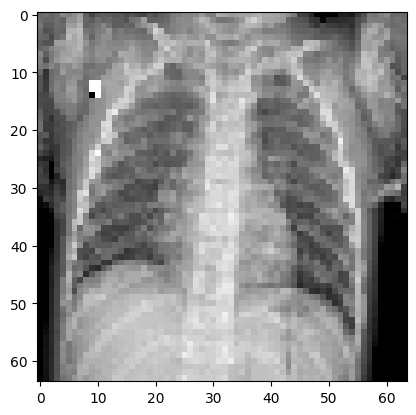

Label: 0.0


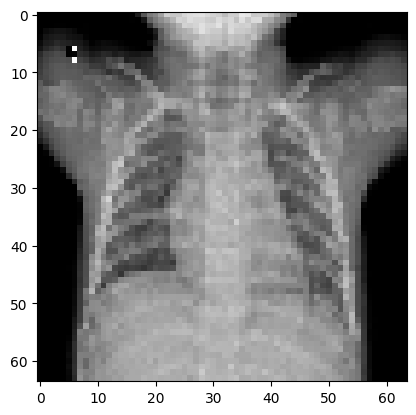

Label: 0.0


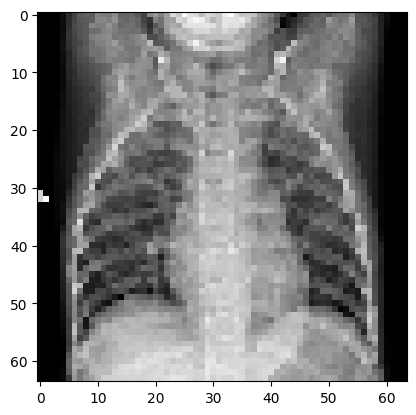

Label: 0.0


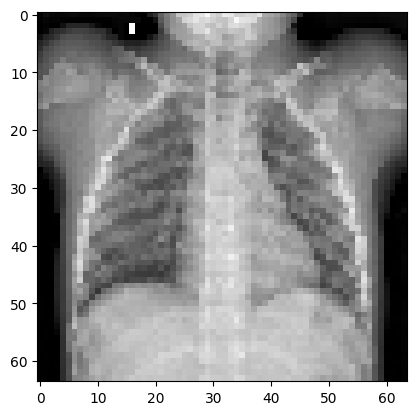

Label: 0.0


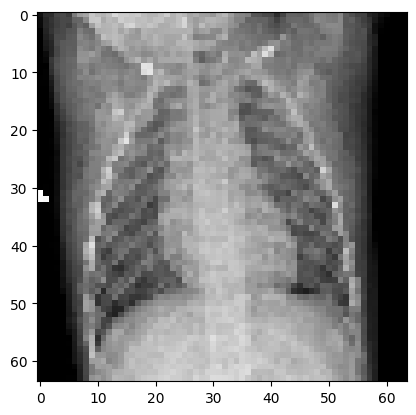

Label: 0.0


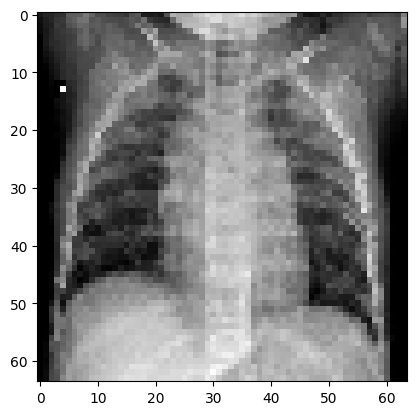

Label: 0.0


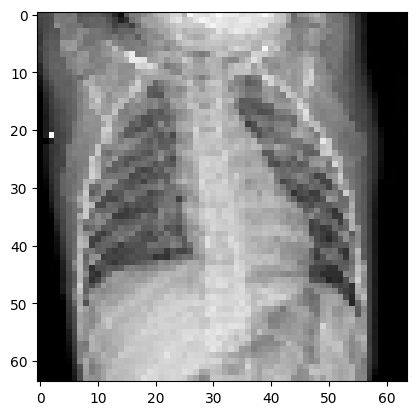

Label: 0.0


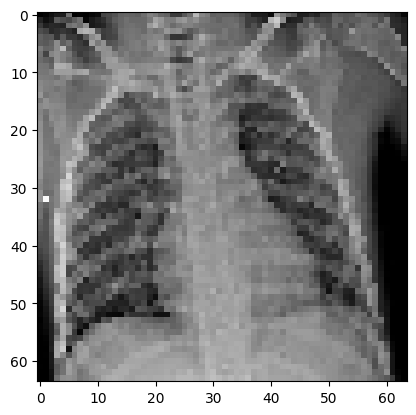

Label: 0.0


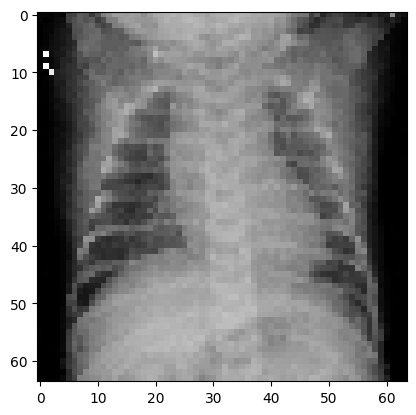

Label: 0.0


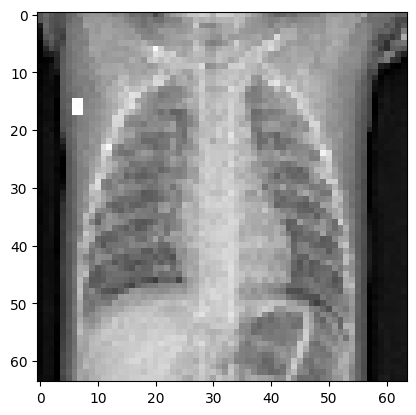

Label: 0.0


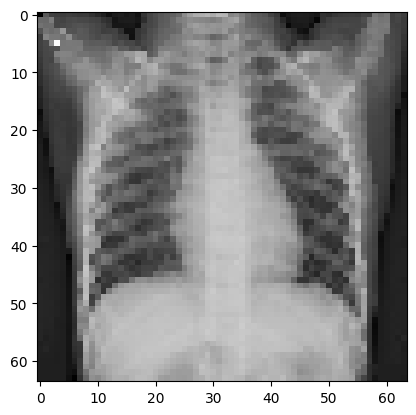

Label: 0.0


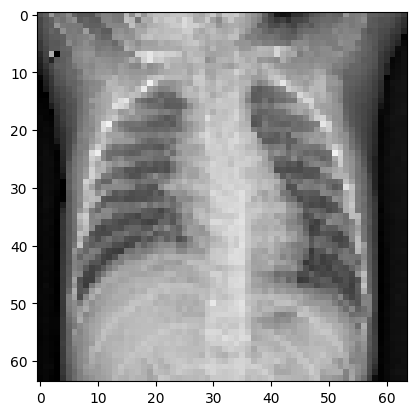

Label: 0.0


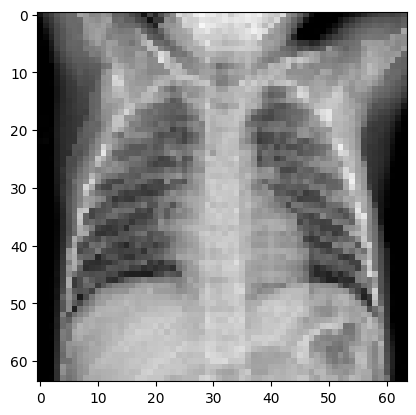

Label: 0.0


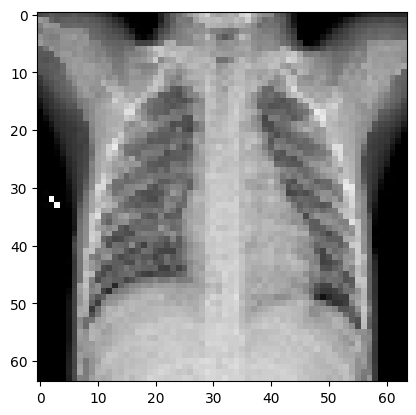

Label: 0.0


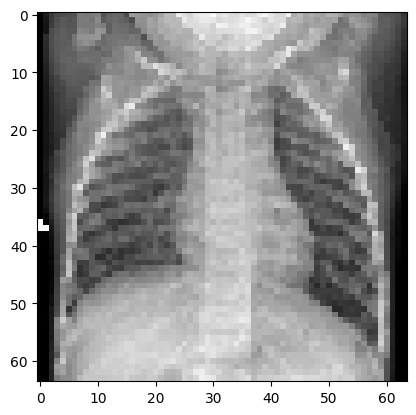

Label: 0.0


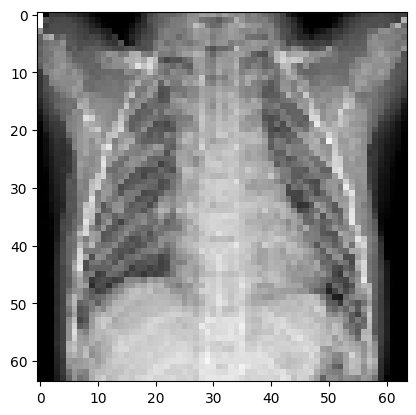

Label: 0.0


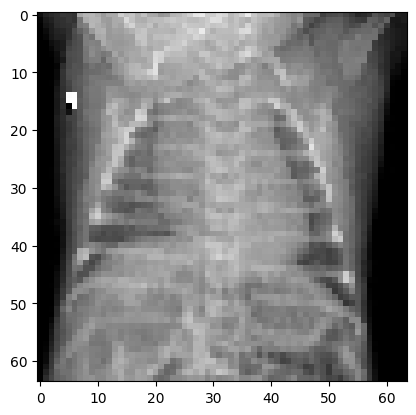

Label: 0.0


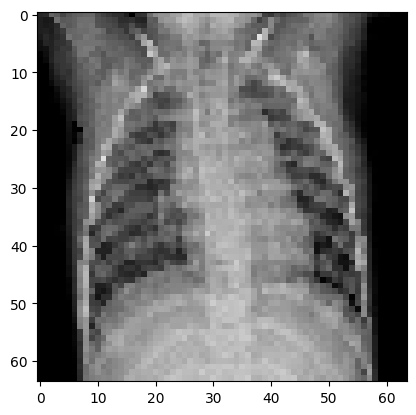

Label: 0.0


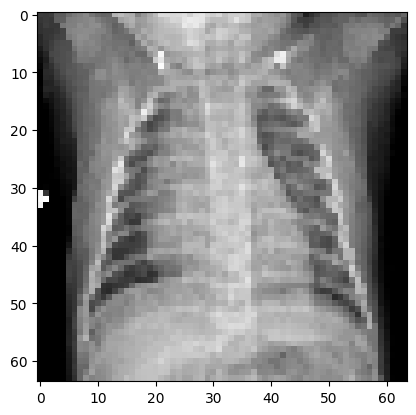

Label: 0.0


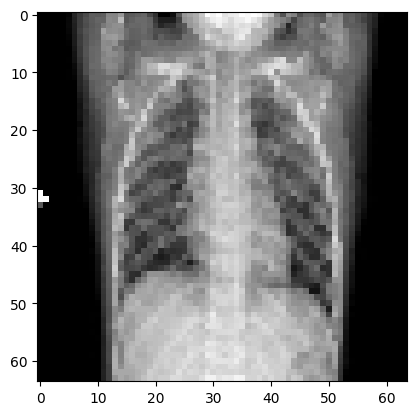

Label: 0.0


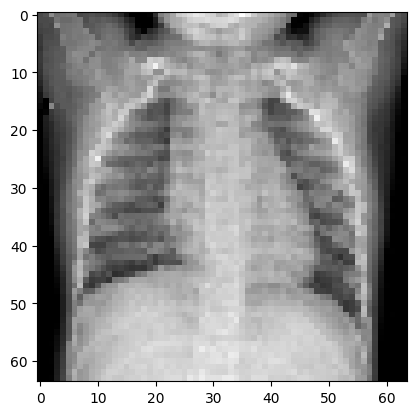

Label: 0.0


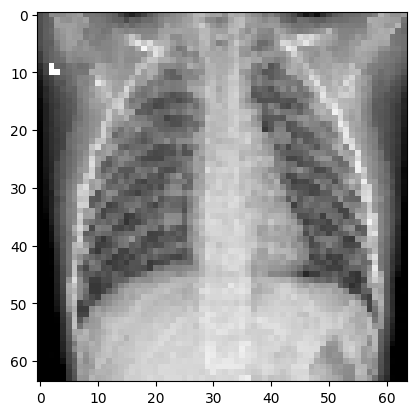

Label: 0.0


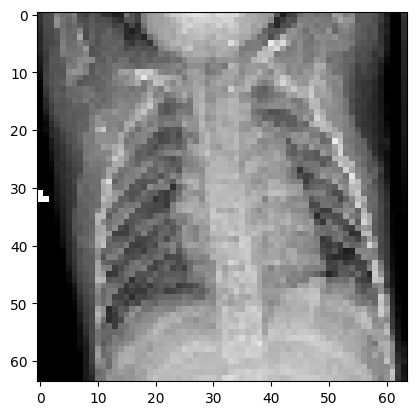

Label: 0.0


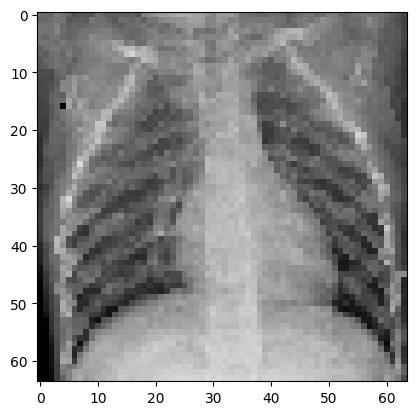

Label: 0.0


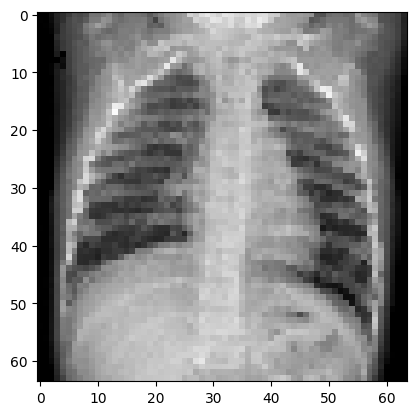

Label: 0.0


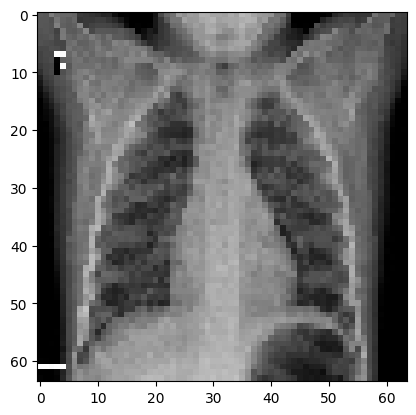

Label: 0.0


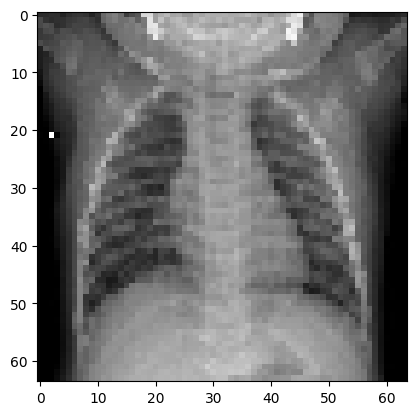

Label: 0.0


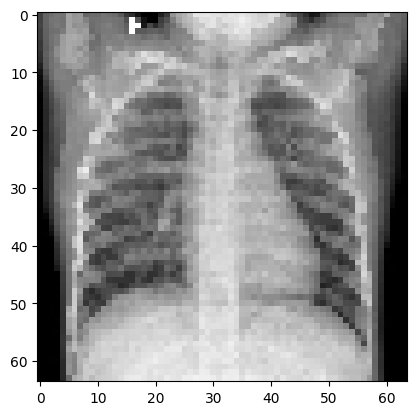

Label: 0.0


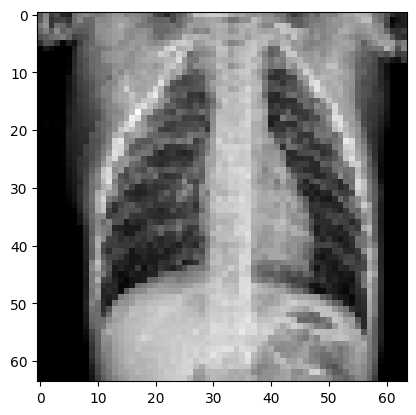

Label: 0.0


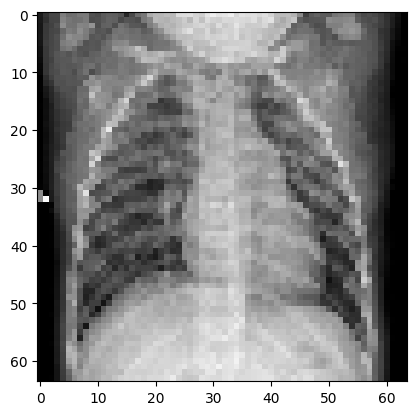

Label: 0.0


KeyboardInterrupt: 

In [174]:
# use a loop to visualize just PNEUMONIA images

### YOUR CODE HERE
healthyIndices = np.where(y_train == 0)[0]
for i in healthyIndices:
  plot_images(X_train, y_train, i)
### END CODE



Like we saw, an image is a 3D array with (y_location, x_location, rgb). Another way of saying this is that an image is a STACK of color matrices. Let's make this more tangible by creating a fake "mini" image!

**Notice that we're using a scale of 0 to 1 instead of 0 to 255.**

In [175]:
import numpy as np

tiny_image = np.array([[[1, 0, 0],
                       [.5, .5, 0]],
                      [[0, 1, 1],
                       [.1, .2, 1]]])
print (tiny_image)
print ("Dimensions: ", tiny_image.shape)

[[[1.  0.  0. ]
  [0.5 0.5 0. ]]

 [[0.  1.  1. ]
  [0.1 0.2 1. ]]]
Dimensions:  (2, 2, 3)


**How many pixels are in our image? What does each number mean?**

Let's plot our tiny image! Do the colors match what you expected?



Label: 


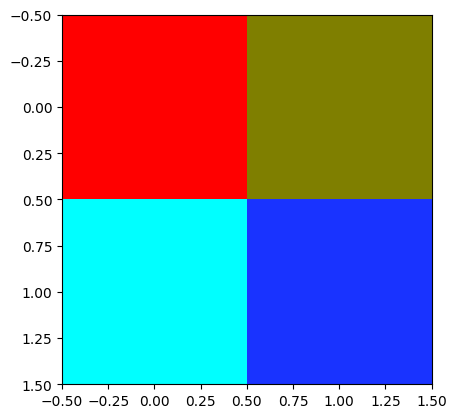

In [176]:
plot_images(tiny_image)

**Experiment with changing the numbers to change your tiny image!**

What happens if we "slice" like this?

In [177]:
tiny_image[:,:,2]

array([[0., 0.],
       [1., 1.]])

Let's try changing one of the color dimensions:

In [178]:
new_image = tiny_image.copy() #make a copy so we don't change the original
new_image[:,:,2] = 0

What did this do? Visualize it!!


Label: 


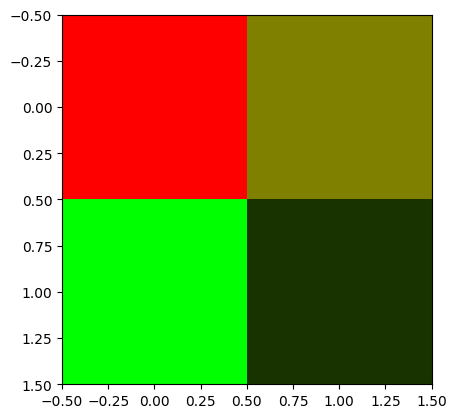

In [179]:
### YOUR CODE HERE
plot_images(new_image)
### END CODE

Now, try to create a blue version of your image. This is know as **tinting.**

(Hint: Zero out the non-blue channels of the image.)

Label: 


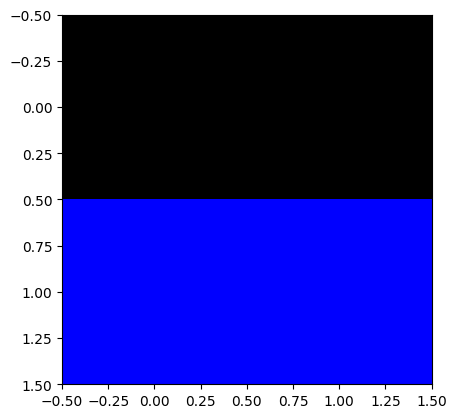

In [180]:
### YOUR CODE HERE
new_image = tiny_image.copy()
new_image[:,:,0] = 0
new_image[:,:,1] = 0

plot_images(new_image)
### END CODE

The first step to doing this is identifying a rectangle in the image. Let's try to color a rectangle in our `rect_image`.

Label: 


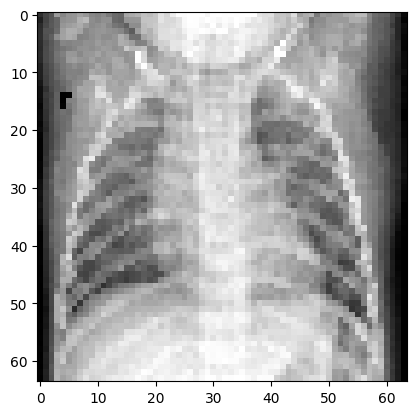

In [181]:
rect_image = image.copy()
plot_images(rect_image)

You can access a pixel at the location (5, 5) in the image like this:


In [182]:
rect_image[5,5]

array([0.5137255, 0.5137255, 0.5137255], dtype=float32)

How would you print the amount of **red** at this pixel?

In [184]:
#YOUR CODE HERE
rect_image[5,5,0]

np.float32(0.5137255)

You can change the color the same way! For example:

```
rect_image[5,5,0] = 0.5
```

Try making a **single** pixel in our image bright red.

Label: 


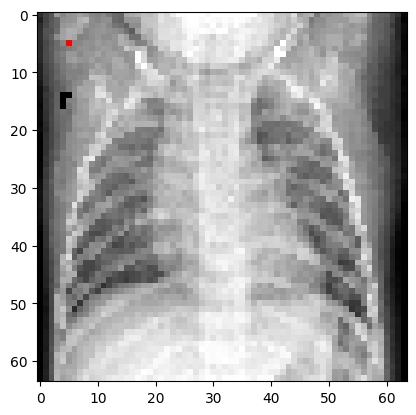

In [185]:
#YOUR CODE HERE
rect_image[5,5,0] = 1
rect_image[5,5,1] = 0
rect_image[5,5,2] = 0

plot_images(rect_image)

**Challenge:** With this in mind, can you write a for loop to draw a red rectangle on our image?

Label: 


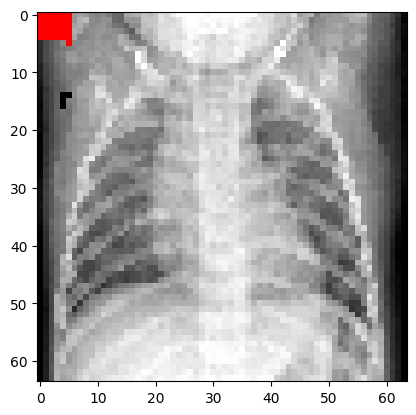

In [186]:
### YOUR CODE HERE
for i in range(5):
  for j in range(6):
    rect_image[i,j,0] = 1
    rect_image[i,j,1] = 0
    rect_image[i,j,2] = 0

plot_images(rect_image)
### END CODE

Today, we'll use some of the Scikit-learn approaches you've seen before. You'll build classifiers on your dataset and see how well you do!

`Sklearn` takes in 'flat' data: that is, data that looks like a table, and is just samples x features. We'll need to **flatten** our 64 x 64 x 3 images, like this:

In [187]:
X_train, y_train = get_train_data(flatten = True)

Can you print out and explain the **shape** of  `X_train` and `y_train`?

In [188]:
#YOUR CODE HERE
print(X_train.shape)
y_train.shape

(2000, 12288)


(2000,)

Please get `X_test` and `y_test` ready the same way, using `get_test_data`:

In [189]:
#YOUR CODE HERE
X_test, y_test = get_test_data(flatten = True)

###Creating Baseline Models

We've tried a few models in sklearn since last week. Below, we list them with some sample parameters:
* `knn = KNeighborsClassifier(n_neighbors = 5)`
* `log = LogisticRegression(max_iter = 1000)`
* `dt = DecisionTreeClassifier(max_depth = 2)`
* others you can find [here](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html) (try MLPClassifier!)

Please **try out a few models**, following each step of the machine learning pipeline:
- Set up a model
- Train (fit) your model
- Predict
- Score using `accuracy_score`

*Hint:* Check out the Conscientious Cars notebook for examples!


**Try to build the best model that you can!**

Vary the parameters of your code.

In [190]:
#Set up, train, predict, and score!
### USE AS MANY CELLS AS YOU WANT!
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)
outp = knn.predict(X_test)
avg = accuracy_score(y_test, outp)
print(avg * 100)

70.25
